In [1]:
import os
import cv2
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
from functions_v2 import(import_train_folder_dataset_2, 
                      Data_2, 
                      plot_loss_accuracy, 
                      accuracy_given_set,
                      import_test_folder_dataset_2,
                      Data_test_2,
                      make_predictions,
                      save_predictions_as_csv,
                      save_model,
                      save_metrics)

# 1. Build your own convolutional neural network using pytorch

In [4]:
# Learning parameters.
epochs = 500 # Number of epochs to train the model
lr = 0.01 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 100 epochs


model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 1/CheckPoints/"

cuda


In [5]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        
        '''
        In dimension:              224 * 224 * 3 
        Out dimension Conv:        224 * 224 * 6
        Out dimension MaxPooling:  112 * 112 * 6
        '''
        self.cnn1_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1, padding=1)
        )
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        
        
        '''
        In dimension:              112 * 112 * 6 
        Out dimension Conv:        112 * 112 * 9
        Out dimension MaxPooling:  56  * 56  * 9
        '''
        self.cnn2_model = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=9, kernel_size=9, stride=1, padding=4),
            nn.ReLU()
        )
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              56  * 56  * 9
        Out dimension Conv:        56  * 56  * 12
        Out dimension MaxPooling:  28  * 28  * 12
        '''
        self.cnn3_model = nn.Sequential(
            nn.Conv2d(in_channels=9, out_channels=12, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
        )
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              28  * 28  * 12
        Out dimension Conv:        28  * 28  * 15
        Out dimension MaxPooling:  7  * 7  * 15
        '''
        self.cnn4_model = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
        )
        self.maxpool4 = nn.MaxPool2d(4, stride=4)
        
        
        
        self.ffnn_model = nn.Sequential(
            nn.Linear(in_features=735, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=4)
        )
        
        
        
    def forward(self, x): 
        
        # Convolution
        x = self.cnn1_model(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool1(x)
        
        # Convolution
        x = self.cnn2_model(x)
        # Max pooling
        x = self.maxpool2(x)
        
        
        # Convolution
        x = self.cnn3_model(x)
        # Max pooling
        x = self.maxpool3(x)
        
        
        # Convolution
        x = self.cnn4_model(x)
        # Max pooling
        x = self.maxpool4(x)
        
        
        
        x = torch.flatten(x,start_dim=1)
        x = self.ffnn_model(x)
        x = torch.sigmoid(x)
        return x

In [6]:
#PyTorch - Visualizing the Model
modelpy = ClassificationNet().to(device) # Get the model, and if there is a GPU use it
print("model created")
# Loss function.
criterion = nn.CrossEntropyLoss() # Set the loss function to cross entropy loss
# Optimizer.
optim = torch.optim.SGD(modelpy.parameters(), lr=lr)# , momentum=0.9, weight_decay=1e-3


# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt.pth"):
        print("Loading save chackpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_check = checkpoint['epoch']
        criterion = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {epoch_check}")


modelpy

model created


ClassificationNet(
  (cnn1_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_model): Sequential(
    (0): Conv2d(6, 9, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3_model): Sequential(
    (0): Conv2d(9, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn4_model): Sequential(
    (0): Conv2d(12, 15, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (maxpool4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (ffnn_model): Sequential(
    (0): Linear(in_features=735, out_

In [7]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 108128


# Load Data

In [8]:
# Path of the files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Test"

In [9]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.Resize((275, 275)),
                                    #transforms.CenterCrop((224, 224)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [10]:
# Import the data into a resized 224x224 images
size_of_resized_img = (224,224) 
train_data, train_labels = import_train_folder_dataset_2(train_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", train_data.shape)
print("Dim of Lables: ", train_labels.shape)

Dim of Data:  (1149, 224, 224, 3)
Dim of Lables:  (1149,)


In [11]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 224, 224, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 224, 224, 3)
Dim of y_test:  (115,)


In [12]:
# Create the dataset object
train_Dataset = Data_2(X_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data_2(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [13]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

In [14]:
print("Type of object: ",type(train_loader))

print()
print( 'Train Size: ' + str(len(train_loader)))
print( 'Validate Size: ' + str(len(valid_loader)))

print()
print("Content of one element: ",iter(train_loader).next())

print()
print("Type of one element: ", type(iter(train_loader).next()))
print("Length of one element: ", len(iter(train_loader).next()))

print()
print('Input tensors size: ' + str(iter(train_loader).next()[0].shape)) # Input: 16, 16875 | 16 train batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(train_loader).next()[1].shape)) # Label: 16 | 16 train Batch size


print()
print('Input tensors size: ' + str(iter(valid_loader).next()[0].shape)) # Input: 8, 16875 | 8 validation batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(valid_loader).next()[1].shape)) # Label: 8 | 8 validation Batch size


Type of object:  <class 'torch.utils.data.dataloader.DataLoader'>

Train Size: 65
Validate Size: 15

Content of one element:  [tensor([[[[-1.2959, -1.3130, -1.3644,  ..., -2.1179, -2.1179, -2.1179],
          [-1.2959, -1.3130, -1.3644,  ..., -2.1179, -2.1179, -2.1179],
          [-1.3302, -1.3302, -1.3473,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-1.2788, -1.2959, -1.3302,  ..., -1.3644, -1.3644, -1.3473],
          [-1.2959, -1.2959, -1.3302,  ..., -1.3473, -1.3644, -1.3815],
          [-1.2959, -1.2788, -1.3130,  ..., -1.3302, -1.3644, -1.4158]],

         [[-0.9678, -0.9853, -1.0378,  ..., -2.0357, -2.0357, -2.0357],
          [-0.9678, -0.9853, -1.0378,  ..., -2.0357, -2.0357, -2.0357],
          [-1.0028, -1.0028, -1.0203,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-1.0378, -1.0728, -1.1078,  ..., -1.0553, -1.0553, -1.0378],
          [-1.0553, -1.0728, -1.1078,  ..., -1.0378, -1.0553, -1.0728],
          [-1.0553, -1.0553, -1.0903,  ..., -1.02

# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 


Epoch 1 of 500


100%|██████████| 15/15 [00:00<00:00, 33.80it/s]


train loss:  0.087133109684839
Val loss:  0.18028202056884765
train accuracy:  0.2611218568665377
Val accuracy:  0.4260869565217391
Current time: 0.242 minutes. Time expected till completion: 120.584 minutes

Epoch 2 of 500


100%|██████████| 15/15 [00:00<00:00, 37.14it/s]


train loss:  0.08658340532959545
Val loss:  0.17860413323278013
train accuracy:  0.5386847195357833
Val accuracy:  0.4956521739130435
Current time: 0.388 minutes. Time expected till completion: 96.718 minutes

Epoch 3 of 500


100%|██████████| 15/15 [00:00<00:00, 29.61it/s]


train loss:  0.0821508323662055
Val loss:  0.15645424386729365
train accuracy:  0.4381044487427466
Val accuracy:  0.4782608695652174
Current time: 0.551 minutes. Time expected till completion: 91.234 minutes

Epoch 4 of 500


100%|██████████| 15/15 [00:00<00:00, 32.63it/s]


train loss:  0.07554273367850416
Val loss:  0.15268463777459185
train accuracy:  0.5009671179883946
Val accuracy:  0.4608695652173913
Current time: 0.719 minutes. Time expected till completion: 89.122 minutes

Epoch 5 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.07488458437891947
Val loss:  0.15240534492160962
train accuracy:  0.3965183752417795
Val accuracy:  0.40869565217391307
Current time: 0.890 minutes. Time expected till completion: 88.102 minutes

Epoch 6 of 500


100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


train loss:  0.07490729616965731
Val loss:  0.1522656948670097
train accuracy:  0.38781431334622823
Val accuracy:  0.40869565217391307
Current time: 1.060 minutes. Time expected till completion: 87.296 minutes

Epoch 7 of 500


100%|██████████| 15/15 [00:00<00:00, 30.57it/s]


train loss:  0.0748001139906435
Val loss:  0.1521269124487172
train accuracy:  0.38781431334622823
Val accuracy:  0.40869565217391307
Current time: 1.230 minutes. Time expected till completion: 86.652 minutes

Epoch 8 of 500


100%|██████████| 15/15 [00:00<00:00, 30.82it/s]


train loss:  0.0747114766381926
Val loss:  0.15204907137414683
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 1.418 minutes. Time expected till completion: 87.182 minutes

Epoch 9 of 500


100%|██████████| 15/15 [00:00<00:00, 29.32it/s]


train loss:  0.07483585181734317
Val loss:  0.15181496143341064
train accuracy:  0.38878143133462284
Val accuracy:  0.40869565217391307
Current time: 1.602 minutes. Time expected till completion: 87.372 minutes

Epoch 10 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.07473312159802051
Val loss:  0.15176402382228685
train accuracy:  0.38781431334622823
Val accuracy:  0.40869565217391307
Current time: 1.782 minutes. Time expected till completion: 87.294 minutes

Epoch 11 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.07460967859170423
Val loss:  0.1519836664199829
train accuracy:  0.38878143133462284
Val accuracy:  0.40869565217391307
Current time: 1.960 minutes. Time expected till completion: 87.119 minutes

Epoch 12 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.07449272119330252
Val loss:  0.15215331264164136
train accuracy:  0.38781431334622823
Val accuracy:  0.40869565217391307
Current time: 2.128 minutes. Time expected till completion: 86.537 minutes

Epoch 13 of 500


100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


train loss:  0.0748944196064652
Val loss:  0.15189128544019617
train accuracy:  0.38684719535783363
Val accuracy:  0.40869565217391307
Current time: 2.298 minutes. Time expected till completion: 86.083 minutes

Epoch 14 of 500


100%|██████████| 15/15 [00:00<00:00, 32.48it/s]


train loss:  0.07453291149849588
Val loss:  0.15206033665200938
train accuracy:  0.38878143133462284
Val accuracy:  0.40869565217391307
Current time: 2.475 minutes. Time expected till completion: 85.906 minutes

Epoch 15 of 500


100%|██████████| 15/15 [00:00<00:00, 30.76it/s]


train loss:  0.07474017506411273
Val loss:  0.15183687210083008
train accuracy:  0.38781431334622823
Val accuracy:  0.40869565217391307
Current time: 2.646 minutes. Time expected till completion: 85.548 minutes

Epoch 16 of 500


100%|██████████| 15/15 [00:00<00:00, 29.90it/s]


train loss:  0.07474994705539607
Val loss:  0.1518560440643974
train accuracy:  0.38878143133462284
Val accuracy:  0.40869565217391307
Current time: 2.824 minutes. Time expected till completion: 85.421 minutes

Epoch 17 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.07476103253936399
Val loss:  0.15215515105620675
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 3.005 minutes. Time expected till completion: 85.388 minutes

Epoch 18 of 500


100%|██████████| 15/15 [00:00<00:00, 32.77it/s]


train loss:  0.07484620653914298
Val loss:  0.15218136103256888
train accuracy:  0.38684719535783363
Val accuracy:  0.40869565217391307
Current time: 3.175 minutes. Time expected till completion: 85.021 minutes

Epoch 19 of 500


100%|██████████| 15/15 [00:00<00:00, 33.57it/s]


train loss:  0.07466857322641221
Val loss:  0.1518696665763855
train accuracy:  0.38684719535783363
Val accuracy:  0.40869565217391307
Current time: 3.343 minutes. Time expected till completion: 84.626 minutes

Epoch 20 of 500


100%|██████████| 15/15 [00:00<00:00, 34.03it/s]


train loss:  0.07453648864185326
Val loss:  0.15171535844388215
train accuracy:  0.38781431334622823
Val accuracy:  0.40869565217391307
Current time: 3.513 minutes. Time expected till completion: 84.309 minutes

Epoch 21 of 500


100%|██████████| 15/15 [00:00<00:00, 29.32it/s]


train loss:  0.07453893934965594
Val loss:  0.1518876993137857
train accuracy:  0.38684719535783363
Val accuracy:  0.40869565217391307
Current time: 3.681 minutes. Time expected till completion: 83.957 minutes

Epoch 22 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.07467725383013314
Val loss:  0.15205456173938253
train accuracy:  0.38684719535783363
Val accuracy:  0.40869565217391307
Current time: 3.853 minutes. Time expected till completion: 83.717 minutes

Epoch 23 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.0746975211386985
Val loss:  0.15183302941529647
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 4.026 minutes. Time expected till completion: 83.486 minutes

Epoch 24 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.07464278701195634
Val loss:  0.15193827929704085
train accuracy:  0.38781431334622823
Val accuracy:  0.40869565217391307
Current time: 4.193 minutes. Time expected till completion: 83.152 minutes

Epoch 25 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.07460044344573694
Val loss:  0.15224710184594858
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 4.362 minutes. Time expected till completion: 82.877 minutes

Epoch 26 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.07464221165996456
Val loss:  0.1521377822627192
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 4.532 minutes. Time expected till completion: 82.619 minutes

Epoch 27 of 500


100%|██████████| 15/15 [00:00<00:00, 34.82it/s]


train loss:  0.07458860143240924
Val loss:  0.15190364537031753
train accuracy:  0.38781431334622823
Val accuracy:  0.40869565217391307
Current time: 4.702 minutes. Time expected till completion: 82.368 minutes

Epoch 28 of 500


100%|██████████| 15/15 [00:00<00:00, 28.98it/s]


train loss:  0.07461241954069303
Val loss:  0.15165609432303387
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 4.898 minutes. Time expected till completion: 82.569 minutes

Epoch 29 of 500


100%|██████████| 15/15 [00:00<00:00, 29.78it/s]


train loss:  0.07472062802637569
Val loss:  0.1520257960195127
train accuracy:  0.38878143133462284
Val accuracy:  0.40869565217391307
Current time: 5.099 minutes. Time expected till completion: 82.811 minutes

Epoch 30 of 500


100%|██████████| 15/15 [00:00<00:00, 29.78it/s]


train loss:  0.07466649813163212
Val loss:  0.15187492422435594
train accuracy:  0.38781431334622823
Val accuracy:  0.40869565217391307
Current time: 5.293 minutes. Time expected till completion: 82.918 minutes

Epoch 31 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.07446154623474328
Val loss:  0.15157834706099138
train accuracy:  0.38878143133462284
Val accuracy:  0.40869565217391307
Current time: 5.464 minutes. Time expected till completion: 82.671 minutes

Epoch 32 of 500


100%|██████████| 15/15 [00:00<00:00, 29.84it/s]


train loss:  0.07490578386031913
Val loss:  0.15212375858555668
train accuracy:  0.38781431334622823
Val accuracy:  0.40869565217391307
Current time: 5.644 minutes. Time expected till completion: 82.540 minutes

Epoch 33 of 500


100%|██████████| 15/15 [00:00<00:00, 29.20it/s]


train loss:  0.07466563853350552
Val loss:  0.1521584002867989
train accuracy:  0.38878143133462284
Val accuracy:  0.40869565217391307
Current time: 5.817 minutes. Time expected till completion: 82.319 minutes

Epoch 34 of 500


100%|██████████| 15/15 [00:00<00:00, 30.45it/s]


train loss:  0.07458757575983235
Val loss:  0.1520702776701554
train accuracy:  0.38878143133462284
Val accuracy:  0.40869565217391307
Current time: 5.992 minutes. Time expected till completion: 82.119 minutes

Epoch 35 of 500


100%|██████████| 15/15 [00:00<00:00, 32.77it/s]


train loss:  0.07443089330680597
Val loss:  0.15175444716992587
train accuracy:  0.38781431334622823
Val accuracy:  0.40869565217391307
Current time: 6.167 minutes. Time expected till completion: 81.930 minutes

Epoch 36 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.07456692891840316
Val loss:  0.1519682879033296
train accuracy:  0.38878143133462284
Val accuracy:  0.40869565217391307
Current time: 6.337 minutes. Time expected till completion: 81.671 minutes

Epoch 37 of 500


100%|██████████| 15/15 [00:00<00:00, 31.20it/s]


train loss:  0.07468845177895787
Val loss:  0.1519840183465377
train accuracy:  0.38878143133462284
Val accuracy:  0.40869565217391307
Current time: 6.511 minutes. Time expected till completion: 81.475 minutes

Epoch 38 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.07473867924116566
Val loss:  0.1521039807278177
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 6.686 minutes. Time expected till completion: 81.287 minutes

Epoch 39 of 500


100%|██████████| 15/15 [00:00<00:00, 33.20it/s]


train loss:  0.07469566526680435
Val loss:  0.15200698531192283
train accuracy:  0.38878143133462284
Val accuracy:  0.40869565217391307
Current time: 6.857 minutes. Time expected till completion: 81.054 minutes

Epoch 40 of 500


100%|██████████| 15/15 [00:00<00:00, 32.84it/s]


train loss:  0.07467554293472024
Val loss:  0.15193021867586218
train accuracy:  0.38878143133462284
Val accuracy:  0.40869565217391307
Current time: 7.032 minutes. Time expected till completion: 80.871 minutes

Epoch 41 of 500


100%|██████████| 15/15 [00:00<00:00, 30.82it/s]


train loss:  0.07470716613865452
Val loss:  0.15190924146901005
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 7.204 minutes. Time expected till completion: 80.649 minutes

Epoch 42 of 500


100%|██████████| 15/15 [00:00<00:00, 30.51it/s]


train loss:  0.07460842072617846
Val loss:  0.1520267481389253
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 7.377 minutes. Time expected till completion: 80.444 minutes

Epoch 43 of 500


100%|██████████| 15/15 [00:00<00:00, 30.14it/s]


train loss:  0.07456565808281447
Val loss:  0.1517511487007141
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 7.557 minutes. Time expected till completion: 80.315 minutes

Epoch 44 of 500


100%|██████████| 15/15 [00:00<00:00, 30.20it/s]


train loss:  0.07445562093354748
Val loss:  0.15264144306597502
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 7.731 minutes. Time expected till completion: 80.116 minutes

Epoch 45 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.07466967873693205
Val loss:  0.1521288400110991
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 7.905 minutes. Time expected till completion: 79.924 minutes

Epoch 46 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.07470177036189479
Val loss:  0.1518832160078961
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 8.082 minutes. Time expected till completion: 79.761 minutes

Epoch 47 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.07469525696922318
Val loss:  0.15202823721844216
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 8.256 minutes. Time expected till completion: 79.570 minutes

Epoch 48 of 500


100%|██████████| 15/15 [00:00<00:00, 30.95it/s]


train loss:  0.07456830662731045
Val loss:  0.15175897038501243
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 8.430 minutes. Time expected till completion: 79.381 minutes

Epoch 49 of 500


100%|██████████| 15/15 [00:00<00:00, 30.08it/s]


train loss:  0.07458997256981796
Val loss:  0.15200729162796683
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 8.606 minutes. Time expected till completion: 79.211 minutes

Epoch 50 of 500


100%|██████████| 15/15 [00:00<00:00, 28.76it/s]


train loss:  0.074487783865034
Val loss:  0.15181608614714248
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 8.784 minutes. Time expected till completion: 79.055 minutes

Epoch 51 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.07456351917532472
Val loss:  0.1520822841188182
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 8.958 minutes. Time expected till completion: 78.867 minutes

Epoch 52 of 500


100%|██████████| 15/15 [00:00<00:00, 32.62it/s]


train loss:  0.07462815539749264
Val loss:  0.15209451551022737
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 9.135 minutes. Time expected till completion: 78.703 minutes

Epoch 53 of 500


100%|██████████| 15/15 [00:00<00:00, 30.02it/s]


train loss:  0.07443504441868175
Val loss:  0.15222390786461207
train accuracy:  0.38878143133462284
Val accuracy:  0.40869565217391307
Current time: 9.309 minutes. Time expected till completion: 78.511 minutes

Epoch 54 of 500


100%|██████████| 15/15 [00:00<00:00, 30.95it/s]


train loss:  0.07449135339928781
Val loss:  0.15198399035826973
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 9.483 minutes. Time expected till completion: 78.325 minutes

Epoch 55 of 500


100%|██████████| 15/15 [00:00<00:00, 30.82it/s]


train loss:  0.07463425616922877
Val loss:  0.1518558761347895
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 9.659 minutes. Time expected till completion: 78.146 minutes

Epoch 56 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.07456431974525378
Val loss:  0.1521467053371927
train accuracy:  0.38878143133462284
Val accuracy:  0.40869565217391307
Current time: 9.835 minutes. Time expected till completion: 77.974 minutes

Epoch 57 of 500


100%|██████████| 15/15 [00:00<00:00, 29.61it/s]


train loss:  0.07461816856432238
Val loss:  0.1521380030590555
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 10.011 minutes. Time expected till completion: 77.806 minutes

Epoch 58 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.07468038901139043
Val loss:  0.15204620257667872
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 10.186 minutes. Time expected till completion: 77.628 minutes

Epoch 59 of 500


100%|██████████| 15/15 [00:00<00:00, 30.08it/s]


train loss:  0.0745057041110107
Val loss:  0.15199335658031962
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 10.360 minutes. Time expected till completion: 77.436 minutes

Epoch 60 of 500


100%|██████████| 15/15 [00:00<00:00, 30.38it/s]


train loss:  0.07451929944626828
Val loss:  0.15193149991657423
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 10.533 minutes. Time expected till completion: 77.240 minutes

Epoch 61 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.07424770978709946
Val loss:  0.15213114800660507
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 10.710 minutes. Time expected till completion: 77.077 minutes

Epoch 62 of 500


100%|██████████| 15/15 [00:00<00:00, 29.90it/s]


train loss:  0.07474243560197044
Val loss:  0.15202905095141866
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 10.885 minutes. Time expected till completion: 76.899 minutes

Epoch 63 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.07446817434041597
Val loss:  0.15241455824478814
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 11.060 minutes. Time expected till completion: 76.721 minutes

Epoch 64 of 500


100%|██████████| 15/15 [00:00<00:00, 32.41it/s]


train loss:  0.07471510577709117
Val loss:  0.15216713573621668
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 11.242 minutes. Time expected till completion: 76.585 minutes

Epoch 65 of 500


100%|██████████| 15/15 [00:00<00:00, 29.72it/s]


train loss:  0.07461662564563566
Val loss:  0.1519351285436879
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 11.411 minutes. Time expected till completion: 76.364 minutes

Epoch 66 of 500


100%|██████████| 15/15 [00:00<00:00, 32.55it/s]


train loss:  0.07454469736586226
Val loss:  0.1518132095751555
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 11.582 minutes. Time expected till completion: 76.164 minutes

Epoch 67 of 500


100%|██████████| 15/15 [00:00<00:00, 34.34it/s]


train loss:  0.07466016355289481
Val loss:  0.15200915388439012
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 11.754 minutes. Time expected till completion: 75.960 minutes

Epoch 68 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.07469032892175523
Val loss:  0.1518742649451546
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 11.921 minutes. Time expected till completion: 75.734 minutes

Epoch 69 of 500


100%|██████████| 15/15 [00:00<00:00, 32.07it/s]


train loss:  0.07458700317478734
Val loss:  0.15191573630208555
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 12.101 minutes. Time expected till completion: 75.590 minutes

Epoch 70 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.07452540880706832
Val loss:  0.15181624682053277
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 12.277 minutes. Time expected till completion: 75.416 minutes

Epoch 71 of 500


100%|██████████| 15/15 [00:00<00:00, 32.28it/s]


train loss:  0.07432571174558865
Val loss:  0.15212554413339366
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 12.450 minutes. Time expected till completion: 75.227 minutes

Epoch 72 of 500


100%|██████████| 15/15 [00:00<00:00, 32.48it/s]


train loss:  0.07474881214606693
Val loss:  0.15188942111056783
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 12.628 minutes. Time expected till completion: 75.066 minutes

Epoch 73 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.07448009088837201
Val loss:  0.15161029929700104
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 12.802 minutes. Time expected till completion: 74.883 minutes

Epoch 74 of 500


100%|██████████| 15/15 [00:00<00:00, 33.06it/s]


train loss:  0.07457542477078317
Val loss:  0.15184953109077784
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 12.972 minutes. Time expected till completion: 74.678 minutes

Epoch 75 of 500


100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


train loss:  0.07449415320353997
Val loss:  0.15186384242513906
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 13.147 minutes. Time expected till completion: 74.498 minutes

Epoch 76 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.0744706800412855
Val loss:  0.15172369480133058
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 13.324 minutes. Time expected till completion: 74.336 minutes

Epoch 77 of 500


100%|██████████| 15/15 [00:00<00:00, 33.27it/s]


train loss:  0.07451869959526873
Val loss:  0.151619073100712
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 13.494 minutes. Time expected till completion: 74.130 minutes

Epoch 78 of 500


100%|██████████| 15/15 [00:00<00:00, 33.80it/s]


train loss:  0.07455492382815082
Val loss:  0.1513773016307665
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 13.665 minutes. Time expected till completion: 73.928 minutes

Epoch 79 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.074488995499491
Val loss:  0.15136104459347932
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 13.833 minutes. Time expected till completion: 73.719 minutes

Epoch 80 of 500


100%|██████████| 15/15 [00:00<00:00, 33.13it/s]


train loss:  0.0745046571098859
Val loss:  0.1513823317444843
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 14.002 minutes. Time expected till completion: 73.511 minutes

Epoch 81 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.07432291355538875
Val loss:  0.15129533487817515
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 14.174 minutes. Time expected till completion: 73.320 minutes

Epoch 82 of 500


100%|██████████| 15/15 [00:00<00:00, 29.84it/s]


train loss:  0.0744003395277942
Val loss:  0.15129069711851037
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 14.343 minutes. Time expected till completion: 73.113 minutes

Epoch 83 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.07453594516739394
Val loss:  0.15102867302687273
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 14.513 minutes. Time expected till completion: 72.914 minutes

Epoch 84 of 500


100%|██████████| 15/15 [00:00<00:00, 32.07it/s]


train loss:  0.07444991197300142
Val loss:  0.15083315268806788
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 14.687 minutes. Time expected till completion: 72.736 minutes

Epoch 85 of 500


100%|██████████| 15/15 [00:00<00:00, 32.84it/s]


train loss:  0.07421575806588222
Val loss:  0.1508972458217455
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 14.854 minutes. Time expected till completion: 72.524 minutes

Epoch 86 of 500


100%|██████████| 15/15 [00:00<00:00, 32.91it/s]


train loss:  0.07432232990255669
Val loss:  0.15073597793993743
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 15.024 minutes. Time expected till completion: 72.323 minutes

Epoch 87 of 500


100%|██████████| 15/15 [00:00<00:00, 30.95it/s]


train loss:  0.07424429462541694
Val loss:  0.15102508223575095
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 15.194 minutes. Time expected till completion: 72.126 minutes

Epoch 88 of 500


100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


train loss:  0.07427823024746066
Val loss:  0.15075682505317356
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 15.362 minutes. Time expected till completion: 71.920 minutes

Epoch 89 of 500


100%|██████████| 15/15 [00:00<00:00, 32.98it/s]


train loss:  0.07438071247918002
Val loss:  0.15050956684610117
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 15.532 minutes. Time expected till completion: 71.724 minutes

Epoch 90 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.07408998090939549
Val loss:  0.15074794603430708
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 15.701 minutes. Time expected till completion: 71.528 minutes

Epoch 91 of 500


100%|██████████| 15/15 [00:00<00:00, 32.77it/s]


train loss:  0.0744870022602192
Val loss:  0.15113253748935201
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 15.871 minutes. Time expected till completion: 71.334 minutes

Epoch 92 of 500


100%|██████████| 15/15 [00:00<00:00, 31.86it/s]


train loss:  0.0742050603579737
Val loss:  0.15069734583730282
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 16.039 minutes. Time expected till completion: 71.129 minutes

Epoch 93 of 500


100%|██████████| 15/15 [00:00<00:00, 30.14it/s]


train loss:  0.07438212448669818
Val loss:  0.15112661382426387
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 16.209 minutes. Time expected till completion: 70.937 minutes

Epoch 94 of 500


100%|██████████| 15/15 [00:00<00:00, 32.62it/s]


train loss:  0.07432066788986988
Val loss:  0.15093227573063062
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 16.382 minutes. Time expected till completion: 70.757 minutes

Epoch 95 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.07433961069560835
Val loss:  0.15043107582175214
train accuracy:  0.390715667311412
Val accuracy:  0.40869565217391307
Current time: 16.553 minutes. Time expected till completion: 70.566 minutes

Epoch 96 of 500


100%|██████████| 15/15 [00:00<00:00, 29.72it/s]


train loss:  0.07434009739001439
Val loss:  0.15129787196283756
train accuracy:  0.390715667311412
Val accuracy:  0.40869565217391307
Current time: 16.722 minutes. Time expected till completion: 70.373 minutes

Epoch 97 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.07435814405087116
Val loss:  0.15182798116103463
train accuracy:  0.39361702127659576
Val accuracy:  0.45217391304347826
Current time: 16.896 minutes. Time expected till completion: 70.195 minutes

Epoch 98 of 500


100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


train loss:  0.07418220923993758
Val loss:  0.15087377714074177
train accuracy:  0.4458413926499033
Val accuracy:  0.4260869565217391
Current time: 17.067 minutes. Time expected till completion: 70.008 minutes

Epoch 99 of 500


100%|██████████| 15/15 [00:00<00:00, 33.13it/s]


train loss:  0.07258846923507159
Val loss:  0.15362249664638353
train accuracy:  0.39264990328820115
Val accuracy:  0.4782608695652174
Current time: 17.234 minutes. Time expected till completion: 69.806 minutes

Epoch 100 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.07179758719364955
Val loss:  0.14876809482989103
train accuracy:  0.41682785299806574
Val accuracy:  0.48695652173913045
Saving model checkpoint


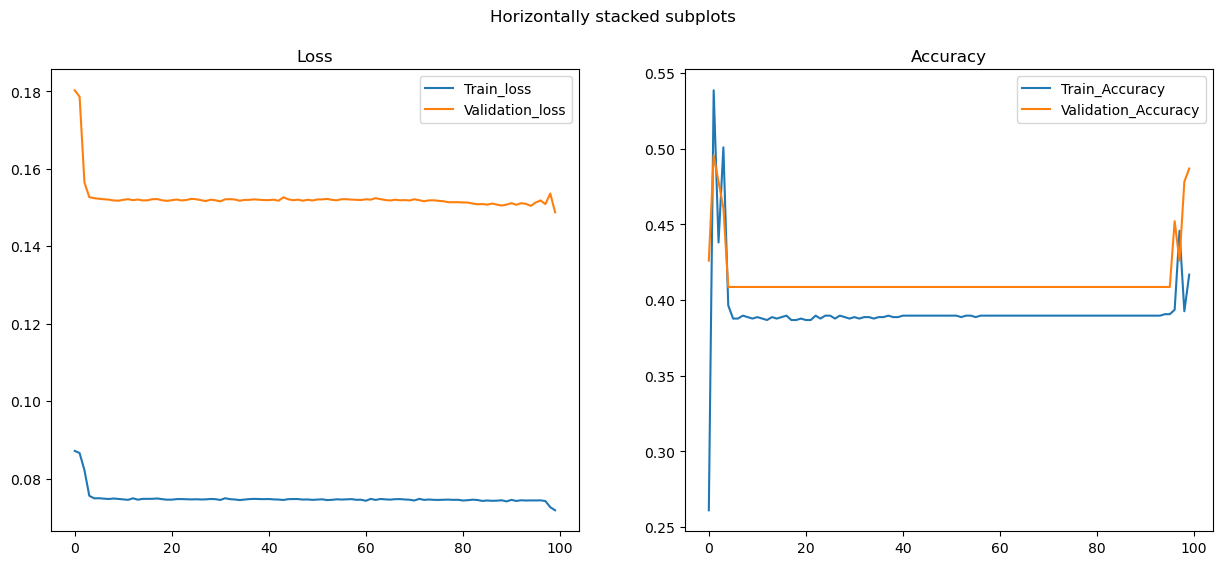

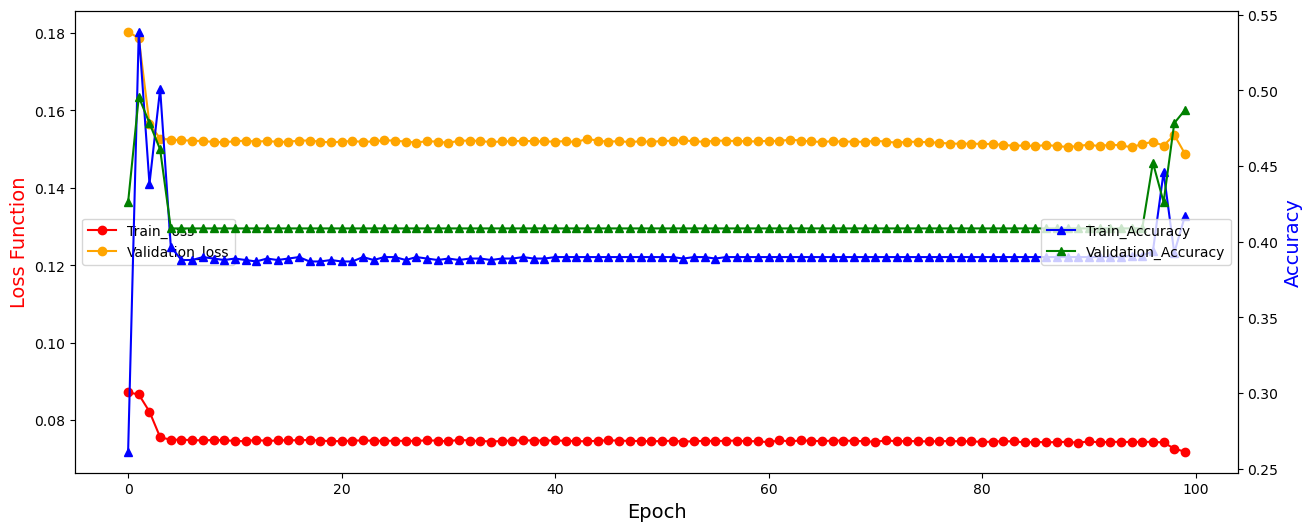

Current time: 17.427 minutes. Time expected till completion: 69.709 minutes

Epoch 101 of 500


100%|██████████| 15/15 [00:00<00:00, 30.82it/s]


train loss:  0.07214042884468802
Val loss:  0.14932869620945144
train accuracy:  0.4410058027079304
Val accuracy:  0.43478260869565216
Current time: 17.601 minutes. Time expected till completion: 69.531 minutes

Epoch 102 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.07208740843795024
Val loss:  0.15031979032184767
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 17.770 minutes. Time expected till completion: 69.337 minutes

Epoch 103 of 500


100%|██████████| 15/15 [00:00<00:00, 30.51it/s]


train loss:  0.07165330475488069
Val loss:  0.15084957143534786
train accuracy:  0.44294003868471954
Val accuracy:  0.6
Current time: 17.942 minutes. Time expected till completion: 69.156 minutes

Epoch 104 of 500


100%|██████████| 15/15 [00:00<00:00, 32.21it/s]


train loss:  0.07230634938356263
Val loss:  0.14978879742000414
train accuracy:  0.5183752417794971
Val accuracy:  0.5739130434782609
Current time: 18.118 minutes. Time expected till completion: 68.988 minutes

Epoch 105 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.07225522058844797
Val loss:  0.14950477869614312
train accuracy:  0.5193423597678917
Val accuracy:  0.5565217391304348
Current time: 18.288 minutes. Time expected till completion: 68.797 minutes

Epoch 106 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.07144894037302044
Val loss:  0.1488708231760108
train accuracy:  0.4825918762088975
Val accuracy:  0.5391304347826087
Current time: 18.457 minutes. Time expected till completion: 68.605 minutes

Epoch 107 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.07160881363446293
Val loss:  0.14900423443835714
train accuracy:  0.45357833655706
Val accuracy:  0.5217391304347826
Current time: 18.631 minutes. Time expected till completion: 68.431 minutes

Epoch 108 of 500


100%|██████████| 15/15 [00:00<00:00, 32.63it/s]


train loss:  0.07180193960090209
Val loss:  0.15070799589157105
train accuracy:  0.49709864603481624
Val accuracy:  0.6173913043478261
Current time: 18.799 minutes. Time expected till completion: 68.234 minutes

Epoch 109 of 500


100%|██████████| 15/15 [00:00<00:00, 31.20it/s]


train loss:  0.07170552424582106
Val loss:  0.15200591916623324
train accuracy:  0.4941972920696325
Val accuracy:  0.5826086956521739
Current time: 18.972 minutes. Time expected till completion: 68.054 minutes

Epoch 110 of 500


100%|██████████| 15/15 [00:00<00:00, 30.38it/s]


train loss:  0.07181477050947267
Val loss:  0.14933475152305933
train accuracy:  0.5406189555125726
Val accuracy:  0.5565217391304348
Current time: 19.138 minutes. Time expected till completion: 67.854 minutes

Epoch 111 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.07162030130567126
Val loss:  0.14928823968638544
train accuracy:  0.5203094777562862
Val accuracy:  0.591304347826087
Current time: 19.308 minutes. Time expected till completion: 67.667 minutes

Epoch 112 of 500


100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


train loss:  0.07147100302651957
Val loss:  0.14840162526006284
train accuracy:  0.504835589941973
Val accuracy:  0.5826086956521739
Current time: 19.479 minutes. Time expected till completion: 67.482 minutes

Epoch 113 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.07131380805425072
Val loss:  0.1491390865782033
train accuracy:  0.5154738878143134
Val accuracy:  0.5652173913043478
Current time: 19.646 minutes. Time expected till completion: 67.284 minutes

Epoch 114 of 500


100%|██████████| 15/15 [00:00<00:00, 33.06it/s]


train loss:  0.07150628961031856
Val loss:  0.1511587256970613
train accuracy:  0.5367504835589942
Val accuracy:  0.6260869565217392
Current time: 19.817 minutes. Time expected till completion: 67.100 minutes

Epoch 115 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.07163128654546387
Val loss:  0.15039719809656557
train accuracy:  0.5251450676982592
Val accuracy:  0.6347826086956522
Current time: 19.987 minutes. Time expected till completion: 66.912 minutes

Epoch 116 of 500


100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


train loss:  0.07162978270990014
Val loss:  0.150183191506759
train accuracy:  0.5560928433268859
Val accuracy:  0.6086956521739131
Current time: 20.156 minutes. Time expected till completion: 66.722 minutes

Epoch 117 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.07155479038245904
Val loss:  0.1505744182545206
train accuracy:  0.5435203094777563
Val accuracy:  0.6086956521739131
Current time: 20.327 minutes. Time expected till completion: 66.540 minutes

Epoch 118 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.06954276100579267
Val loss:  0.14711046892663707
train accuracy:  0.5696324951644101
Val accuracy:  0.5739130434782609
Current time: 20.496 minutes. Time expected till completion: 66.350 minutes

Epoch 119 of 500


100%|██████████| 15/15 [00:00<00:00, 32.21it/s]


train loss:  0.06894030146718717
Val loss:  0.14181538664776347
train accuracy:  0.5773694390715667
Val accuracy:  0.6521739130434783
Current time: 20.663 minutes. Time expected till completion: 66.158 minutes

Epoch 120 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.06887419092355429
Val loss:  0.14479146781175034
train accuracy:  0.5831721470019342
Val accuracy:  0.6086956521739131
Current time: 20.835 minutes. Time expected till completion: 65.976 minutes

Epoch 121 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06907290277905344
Val loss:  0.1433582394019417
train accuracy:  0.562862669245648
Val accuracy:  0.6434782608695652
Current time: 20.998 minutes. Time expected till completion: 65.772 minutes

Epoch 122 of 500


100%|██████████| 15/15 [00:00<00:00, 34.03it/s]


train loss:  0.06955580571864514
Val loss:  0.1430202753647514
train accuracy:  0.5822050290135397
Val accuracy:  0.6434782608695652
Current time: 21.171 minutes. Time expected till completion: 65.597 minutes

Epoch 123 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.06926493170874723
Val loss:  0.14324792882670526
train accuracy:  0.5764023210831721
Val accuracy:  0.6
Current time: 21.342 minutes. Time expected till completion: 65.414 minutes

Epoch 124 of 500


100%|██████████| 15/15 [00:00<00:00, 32.34it/s]


train loss:  0.0690901632811622
Val loss:  0.14345417178195455
train accuracy:  0.5831721470019342
Val accuracy:  0.6347826086956522
Current time: 21.509 minutes. Time expected till completion: 65.222 minutes

Epoch 125 of 500


100%|██████████| 15/15 [00:00<00:00, 32.63it/s]


train loss:  0.06927657749943392
Val loss:  0.14549676698187122
train accuracy:  0.5667311411992263
Val accuracy:  0.5652173913043478
Current time: 21.683 minutes. Time expected till completion: 65.050 minutes

Epoch 126 of 500


100%|██████████| 15/15 [00:00<00:00, 28.98it/s]


train loss:  0.0689334147096372
Val loss:  0.1432405140088952
train accuracy:  0.5667311411992263
Val accuracy:  0.5739130434782609
Current time: 21.853 minutes. Time expected till completion: 64.864 minutes

Epoch 127 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.06883416179300969
Val loss:  0.14281108016553132
train accuracy:  0.5783365570599613
Val accuracy:  0.6260869565217392
Current time: 22.021 minutes. Time expected till completion: 64.675 minutes

Epoch 128 of 500


100%|██████████| 15/15 [00:00<00:00, 30.57it/s]


train loss:  0.06881679372584566
Val loss:  0.14336843231449956
train accuracy:  0.5822050290135397
Val accuracy:  0.591304347826087
Current time: 22.190 minutes. Time expected till completion: 64.490 minutes

Epoch 129 of 500


100%|██████████| 15/15 [00:00<00:00, 29.32it/s]


train loss:  0.0685420234613769
Val loss:  0.14262580716091652
train accuracy:  0.5725338491295938
Val accuracy:  0.6086956521739131
Current time: 22.361 minutes. Time expected till completion: 64.309 minutes

Epoch 130 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06904045957891808
Val loss:  0.14411916318147078
train accuracy:  0.5812379110251451
Val accuracy:  0.591304347826087
Current time: 22.534 minutes. Time expected till completion: 64.134 minutes

Epoch 131 of 500


100%|██████████| 15/15 [00:00<00:00, 33.42it/s]


train loss:  0.06894903406644928
Val loss:  0.14305398516033008
train accuracy:  0.5705996131528046
Val accuracy:  0.6521739130434783
Current time: 22.703 minutes. Time expected till completion: 63.951 minutes

Epoch 132 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06952943077862148
Val loss:  0.14362991581792417
train accuracy:  0.5754352030947776
Val accuracy:  0.5652173913043478
Current time: 22.875 minutes. Time expected till completion: 63.772 minutes

Epoch 133 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.06870979347358128
Val loss:  0.1444227265275043
train accuracy:  0.5764023210831721
Val accuracy:  0.591304347826087
Current time: 23.048 minutes. Time expected till completion: 63.598 minutes

Epoch 134 of 500


100%|██████████| 15/15 [00:00<00:00, 30.38it/s]


train loss:  0.06821266519954172
Val loss:  0.1428540447483892
train accuracy:  0.597678916827853
Val accuracy:  0.6434782608695652
Current time: 23.220 minutes. Time expected till completion: 63.422 minutes

Epoch 135 of 500


100%|██████████| 15/15 [00:00<00:00, 33.50it/s]


train loss:  0.06870471491573858
Val loss:  0.1404729900152787
train accuracy:  0.5764023210831721
Val accuracy:  0.6173913043478261
Current time: 23.386 minutes. Time expected till completion: 63.230 minutes

Epoch 136 of 500


100%|██████████| 15/15 [00:00<00:00, 33.80it/s]


train loss:  0.06875479082996656
Val loss:  0.14381866195927495
train accuracy:  0.5812379110251451
Val accuracy:  0.5478260869565217
Current time: 23.564 minutes. Time expected till completion: 63.070 minutes

Epoch 137 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06841531937772577
Val loss:  0.1438800423041634
train accuracy:  0.5715667311411993
Val accuracy:  0.5739130434782609
Current time: 23.737 minutes. Time expected till completion: 62.894 minutes

Epoch 138 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.06856985612118498
Val loss:  0.14322088334871375
train accuracy:  0.5851063829787234
Val accuracy:  0.5826086956521739
Current time: 23.905 minutes. Time expected till completion: 62.707 minutes

Epoch 139 of 500


100%|██████████| 15/15 [00:00<00:00, 32.34it/s]


train loss:  0.06877660906983529
Val loss:  0.14539098946944526
train accuracy:  0.5957446808510638
Val accuracy:  0.6086956521739131
Current time: 24.078 minutes. Time expected till completion: 62.533 minutes

Epoch 140 of 500


100%|██████████| 15/15 [00:00<00:00, 30.76it/s]


train loss:  0.06861686850654779
Val loss:  0.14308243989944458
train accuracy:  0.5880077369439072
Val accuracy:  0.5565217391304348
Current time: 24.251 minutes. Time expected till completion: 62.359 minutes

Epoch 141 of 500


100%|██████████| 15/15 [00:00<00:00, 32.07it/s]


train loss:  0.0680002484838091
Val loss:  0.1450056739475416
train accuracy:  0.5686653771760155
Val accuracy:  0.5826086956521739
Current time: 24.419 minutes. Time expected till completion: 62.174 minutes

Epoch 142 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.0678989940270695
Val loss:  0.14394409604694533
train accuracy:  0.6083172147001934
Val accuracy:  0.6347826086956522
Current time: 24.592 minutes. Time expected till completion: 61.999 minutes

Epoch 143 of 500


100%|██████████| 15/15 [00:00<00:00, 30.76it/s]


train loss:  0.06830266706025807
Val loss:  0.1429519922836967
train accuracy:  0.5870406189555126
Val accuracy:  0.6347826086956522
Current time: 24.762 minutes. Time expected till completion: 61.819 minutes

Epoch 144 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.06818118530039169
Val loss:  0.14540618658065796
train accuracy:  0.5831721470019342
Val accuracy:  0.5391304347826087
Current time: 24.934 minutes. Time expected till completion: 61.643 minutes

Epoch 145 of 500


100%|██████████| 15/15 [00:00<00:00, 30.95it/s]


train loss:  0.06870244688406674
Val loss:  0.1426670940025993
train accuracy:  0.5841392649903289
Val accuracy:  0.5826086956521739
Current time: 25.106 minutes. Time expected till completion: 61.467 minutes

Epoch 146 of 500


100%|██████████| 15/15 [00:00<00:00, 31.20it/s]


train loss:  0.06796116190214914
Val loss:  0.14441283215647158
train accuracy:  0.586073500967118
Val accuracy:  0.6260869565217392
Current time: 25.275 minutes. Time expected till completion: 61.283 minutes

Epoch 147 of 500


100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


train loss:  0.06826775827998119
Val loss:  0.1435002456540647
train accuracy:  0.5957446808510638
Val accuracy:  0.6347826086956522
Current time: 25.447 minutes. Time expected till completion: 61.107 minutes

Epoch 148 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.0681989907757226
Val loss:  0.14332409423330555
train accuracy:  0.5880077369439072
Val accuracy:  0.6
Current time: 25.619 minutes. Time expected till completion: 60.932 minutes

Epoch 149 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.06807629317333436
Val loss:  0.14472477125084918
train accuracy:  0.586073500967118
Val accuracy:  0.6260869565217392
Current time: 25.787 minutes. Time expected till completion: 60.746 minutes

Epoch 150 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06799896663807808
Val loss:  0.14383666100709336
train accuracy:  0.5909090909090909
Val accuracy:  0.6173913043478261
Current time: 25.955 minutes. Time expected till completion: 60.562 minutes

Epoch 151 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.06755108621180403
Val loss:  0.14127514725146087
train accuracy:  0.5967117988394585
Val accuracy:  0.5652173913043478
Current time: 26.123 minutes. Time expected till completion: 60.376 minutes

Epoch 152 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06781555784278959
Val loss:  0.1404297491778498
train accuracy:  0.5899419729206963
Val accuracy:  0.6521739130434783
Current time: 26.292 minutes. Time expected till completion: 60.195 minutes

Epoch 153 of 500


100%|██████████| 15/15 [00:00<00:00, 32.77it/s]


train loss:  0.06825682486279559
Val loss:  0.14181420336598935
train accuracy:  0.5918762088974855
Val accuracy:  0.6260869565217392
Current time: 26.462 minutes. Time expected till completion: 60.014 minutes

Epoch 154 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.06785741425344514
Val loss:  0.14078221735746965
train accuracy:  0.59284332688588
Val accuracy:  0.6086956521739131
Current time: 26.631 minutes. Time expected till completion: 59.833 minutes

Epoch 155 of 500


100%|██████████| 15/15 [00:00<00:00, 33.65it/s]


train loss:  0.06853873442635085
Val loss:  0.14477294994437176
train accuracy:  0.5880077369439072
Val accuracy:  0.6521739130434783
Current time: 26.802 minutes. Time expected till completion: 59.655 minutes

Epoch 156 of 500


100%|██████████| 15/15 [00:00<00:00, 34.10it/s]


train loss:  0.06785682835246885
Val loss:  0.14235835645509803
train accuracy:  0.5996131528046421
Val accuracy:  0.6434782608695652
Current time: 26.970 minutes. Time expected till completion: 59.473 minutes

Epoch 157 of 500


100%|██████████| 15/15 [00:00<00:00, 32.84it/s]


train loss:  0.06855263435633085
Val loss:  0.14209140124528305
train accuracy:  0.5870406189555126
Val accuracy:  0.591304347826087
Current time: 27.137 minutes. Time expected till completion: 59.287 minutes

Epoch 158 of 500


100%|██████████| 15/15 [00:00<00:00, 33.65it/s]


train loss:  0.06757181219943949
Val loss:  0.1426340320835943
train accuracy:  0.597678916827853
Val accuracy:  0.6086956521739131
Current time: 27.310 minutes. Time expected till completion: 59.115 minutes

Epoch 159 of 500


100%|██████████| 15/15 [00:00<00:00, 33.06it/s]


train loss:  0.06815490230370305
Val loss:  0.14320627036301986
train accuracy:  0.586073500967118
Val accuracy:  0.6521739130434783
Current time: 27.484 minutes. Time expected till completion: 58.943 minutes

Epoch 160 of 500


100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


train loss:  0.0678442051378394
Val loss:  0.1444641237673552
train accuracy:  0.6005802707930368
Val accuracy:  0.6434782608695652
Current time: 27.653 minutes. Time expected till completion: 58.762 minutes

Epoch 161 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06819139377752632
Val loss:  0.14257014834362527
train accuracy:  0.6044487427466151
Val accuracy:  0.6347826086956522
Current time: 27.824 minutes. Time expected till completion: 58.586 minutes

Epoch 162 of 500


100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


train loss:  0.06806302134026872
Val loss:  0.1424068492391835
train accuracy:  0.5909090909090909
Val accuracy:  0.6521739130434783
Current time: 27.996 minutes. Time expected till completion: 58.412 minutes

Epoch 163 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06799552190465208
Val loss:  0.14200614535290262
train accuracy:  0.5947775628626693
Val accuracy:  0.6086956521739131
Current time: 28.166 minutes. Time expected till completion: 58.234 minutes

Epoch 164 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.06782423942647081
Val loss:  0.1423828741778498
train accuracy:  0.5967117988394585
Val accuracy:  0.6434782608695652
Current time: 28.338 minutes. Time expected till completion: 58.058 minutes

Epoch 165 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06758540984048604
Val loss:  0.14179560775342195
train accuracy:  0.6054158607350096
Val accuracy:  0.6521739130434783
Current time: 28.507 minutes. Time expected till completion: 57.878 minutes

Epoch 166 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.06783384903256622
Val loss:  0.1433708843977555
train accuracy:  0.597678916827853
Val accuracy:  0.6347826086956522
Current time: 28.678 minutes. Time expected till completion: 57.702 minutes

Epoch 167 of 500


100%|██████████| 15/15 [00:00<00:00, 32.98it/s]


train loss:  0.06764783504161428
Val loss:  0.14279432504073433
train accuracy:  0.6054158607350096
Val accuracy:  0.5565217391304348
Current time: 28.850 minutes. Time expected till completion: 57.528 minutes

Epoch 168 of 500


100%|██████████| 15/15 [00:00<00:00, 29.84it/s]


train loss:  0.06797417715854756
Val loss:  0.14188072266785995
train accuracy:  0.6044487427466151
Val accuracy:  0.6434782608695652
Current time: 29.020 minutes. Time expected till completion: 57.350 minutes

Epoch 169 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.06754542377055037
Val loss:  0.13983618072841478
train accuracy:  0.586073500967118
Val accuracy:  0.6260869565217392
Current time: 29.192 minutes. Time expected till completion: 57.175 minutes

Epoch 170 of 500


100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


train loss:  0.06749306005251016
Val loss:  0.14215528394864954
train accuracy:  0.5899419729206963
Val accuracy:  0.6347826086956522
Current time: 29.361 minutes. Time expected till completion: 56.996 minutes

Epoch 171 of 500


100%|██████████| 15/15 [00:00<00:00, 27.80it/s]


train loss:  0.06738645374429064
Val loss:  0.14053599678951761
train accuracy:  0.6015473887814313
Val accuracy:  0.6260869565217392
Current time: 29.533 minutes. Time expected till completion: 56.820 minutes

Epoch 172 of 500


100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


train loss:  0.06741146838411372
Val loss:  0.14225691297779913
train accuracy:  0.6044487427466151
Val accuracy:  0.5565217391304348
Current time: 29.706 minutes. Time expected till completion: 56.649 minutes

Epoch 173 of 500


100%|██████████| 15/15 [00:00<00:00, 29.90it/s]


train loss:  0.06775071496428559
Val loss:  0.1412877336792324
train accuracy:  0.5822050290135397
Val accuracy:  0.5652173913043478
Current time: 29.877 minutes. Time expected till completion: 56.472 minutes

Epoch 174 of 500


100%|██████████| 15/15 [00:00<00:00, 32.48it/s]


train loss:  0.06735411516932961
Val loss:  0.14174161112826802
train accuracy:  0.5996131528046421
Val accuracy:  0.6521739130434783
Current time: 30.047 minutes. Time expected till completion: 56.295 minutes

Epoch 175 of 500


100%|██████████| 15/15 [00:00<00:00, 32.91it/s]


train loss:  0.06784177443275599
Val loss:  0.14614847276521767
train accuracy:  0.59284332688588
Val accuracy:  0.6695652173913044
Current time: 30.220 minutes. Time expected till completion: 56.123 minutes

Epoch 176 of 500


100%|██████████| 15/15 [00:00<00:00, 29.49it/s]


train loss:  0.06783168297441139
Val loss:  0.14165712387665458
train accuracy:  0.5938104448742747
Val accuracy:  0.6173913043478261
Current time: 30.392 minutes. Time expected till completion: 55.950 minutes

Epoch 177 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.06768476530707782
Val loss:  0.1413611826689347
train accuracy:  0.6054158607350096
Val accuracy:  0.5739130434782609
Current time: 30.565 minutes. Time expected till completion: 55.777 minutes

Epoch 178 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06734078102231718
Val loss:  0.14354223479395328
train accuracy:  0.5889748549323017
Val accuracy:  0.6521739130434783
Current time: 30.736 minutes. Time expected till completion: 55.600 minutes

Epoch 179 of 500


100%|██████████| 15/15 [00:00<00:00, 31.07it/s]


train loss:  0.06783738761160314
Val loss:  0.14145489153654678
train accuracy:  0.6054158607350096
Val accuracy:  0.6521739130434783
Current time: 30.905 minutes. Time expected till completion: 55.421 minutes

Epoch 180 of 500


100%|██████████| 15/15 [00:00<00:00, 32.41it/s]


train loss:  0.06767482447439743
Val loss:  0.14470613728398862
train accuracy:  0.6054158607350096
Val accuracy:  0.6434782608695652
Current time: 31.075 minutes. Time expected till completion: 55.244 minutes

Epoch 181 of 500


100%|██████████| 15/15 [00:00<00:00, 33.35it/s]


train loss:  0.06726809212040855
Val loss:  0.1410537144412165
train accuracy:  0.597678916827853
Val accuracy:  0.591304347826087
Current time: 31.248 minutes. Time expected till completion: 55.072 minutes

Epoch 182 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.06773572952650501
Val loss:  0.1414776967919391
train accuracy:  0.6121856866537717
Val accuracy:  0.6
Current time: 31.414 minutes. Time expected till completion: 54.889 minutes

Epoch 183 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06763189316257057
Val loss:  0.1406576649002407
train accuracy:  0.5783365570599613
Val accuracy:  0.6521739130434783
Current time: 31.585 minutes. Time expected till completion: 54.712 minutes

Epoch 184 of 500


100%|██████████| 15/15 [00:00<00:00, 30.95it/s]


train loss:  0.06740751966286443
Val loss:  0.1424053720805956
train accuracy:  0.6044487427466151
Val accuracy:  0.6347826086956522
Current time: 31.756 minutes. Time expected till completion: 54.537 minutes

Epoch 185 of 500


100%|██████████| 15/15 [00:00<00:00, 31.20it/s]


train loss:  0.06713557053119579
Val loss:  0.1428228233171546
train accuracy:  0.6073500967117988
Val accuracy:  0.6434782608695652
Current time: 31.923 minutes. Time expected till completion: 54.355 minutes

Epoch 186 of 500


100%|██████████| 15/15 [00:00<00:00, 32.48it/s]


train loss:  0.0676403451473155
Val loss:  0.14111028495042222
train accuracy:  0.6083172147001934
Val accuracy:  0.6
Current time: 32.092 minutes. Time expected till completion: 54.176 minutes

Epoch 187 of 500


100%|██████████| 15/15 [00:00<00:00, 32.07it/s]


train loss:  0.06733954408182627
Val loss:  0.14298497956732045
train accuracy:  0.6025145067698259
Val accuracy:  0.591304347826087
Current time: 32.262 minutes. Time expected till completion: 54.001 minutes

Epoch 188 of 500


100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


train loss:  0.06741591630867418
Val loss:  0.1428840300311213
train accuracy:  0.5831721470019342
Val accuracy:  0.5652173913043478
Current time: 32.433 minutes. Time expected till completion: 53.824 minutes

Epoch 189 of 500


100%|██████████| 15/15 [00:00<00:00, 33.87it/s]


train loss:  0.06731082277095064
Val loss:  0.14083515301994656
train accuracy:  0.5841392649903289
Val accuracy:  0.5826086956521739
Current time: 32.601 minutes. Time expected till completion: 53.646 minutes

Epoch 190 of 500


100%|██████████| 15/15 [00:00<00:00, 33.27it/s]


train loss:  0.06693586297837632
Val loss:  0.14130545906398606
train accuracy:  0.5947775628626693
Val accuracy:  0.5652173913043478
Current time: 32.769 minutes. Time expected till completion: 53.465 minutes

Epoch 191 of 500


100%|██████████| 15/15 [00:00<00:00, 33.65it/s]


train loss:  0.06688586148348721
Val loss:  0.1405193530994913
train accuracy:  0.6005802707930368
Val accuracy:  0.6608695652173913
Current time: 32.938 minutes. Time expected till completion: 53.286 minutes

Epoch 192 of 500


100%|██████████| 15/15 [00:00<00:00, 32.21it/s]


train loss:  0.0672062065315431
Val loss:  0.14413849115371705
train accuracy:  0.6150870406189555
Val accuracy:  0.6521739130434783
Current time: 33.109 minutes. Time expected till completion: 53.112 minutes

Epoch 193 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.0678621671762411
Val loss:  0.1446534856506016
train accuracy:  0.6054158607350096
Val accuracy:  0.6521739130434783
Current time: 33.279 minutes. Time expected till completion: 52.936 minutes

Epoch 194 of 500


100%|██████████| 15/15 [00:00<00:00, 33.65it/s]


train loss:  0.06734033473686277
Val loss:  0.14318679778472237
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 33.449 minutes. Time expected till completion: 52.760 minutes

Epoch 195 of 500


100%|██████████| 15/15 [00:00<00:00, 33.35it/s]


train loss:  0.06723086878916743
Val loss:  0.14219809148622595
train accuracy:  0.6054158607350096
Val accuracy:  0.6782608695652174
Current time: 33.619 minutes. Time expected till completion: 52.584 minutes

Epoch 196 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06714335089725959
Val loss:  0.1408269861470098
train accuracy:  0.6015473887814313
Val accuracy:  0.6086956521739131
Current time: 33.788 minutes. Time expected till completion: 52.406 minutes

Epoch 197 of 500


100%|██████████| 15/15 [00:00<00:00, 32.84it/s]


train loss:  0.06702698833476645
Val loss:  0.14081427118052606
train accuracy:  0.6189555125725339
Val accuracy:  0.5826086956521739
Current time: 33.956 minutes. Time expected till completion: 52.227 minutes

Epoch 198 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.0670644088686089
Val loss:  0.1419408803400786
train accuracy:  0.6005802707930368
Val accuracy:  0.5391304347826087
Current time: 34.128 minutes. Time expected till completion: 52.053 minutes

Epoch 199 of 500


100%|██████████| 15/15 [00:00<00:00, 32.91it/s]


train loss:  0.06721852324917423
Val loss:  0.14187256045963453
train accuracy:  0.59284332688588
Val accuracy:  0.591304347826087
Current time: 34.294 minutes. Time expected till completion: 51.873 minutes

Epoch 200 of 500


100%|██████████| 15/15 [00:00<00:00, 33.42it/s]


train loss:  0.06730012304547676
Val loss:  0.14109019974003667
train accuracy:  0.5967117988394585
Val accuracy:  0.5826086956521739
Saving model checkpoint


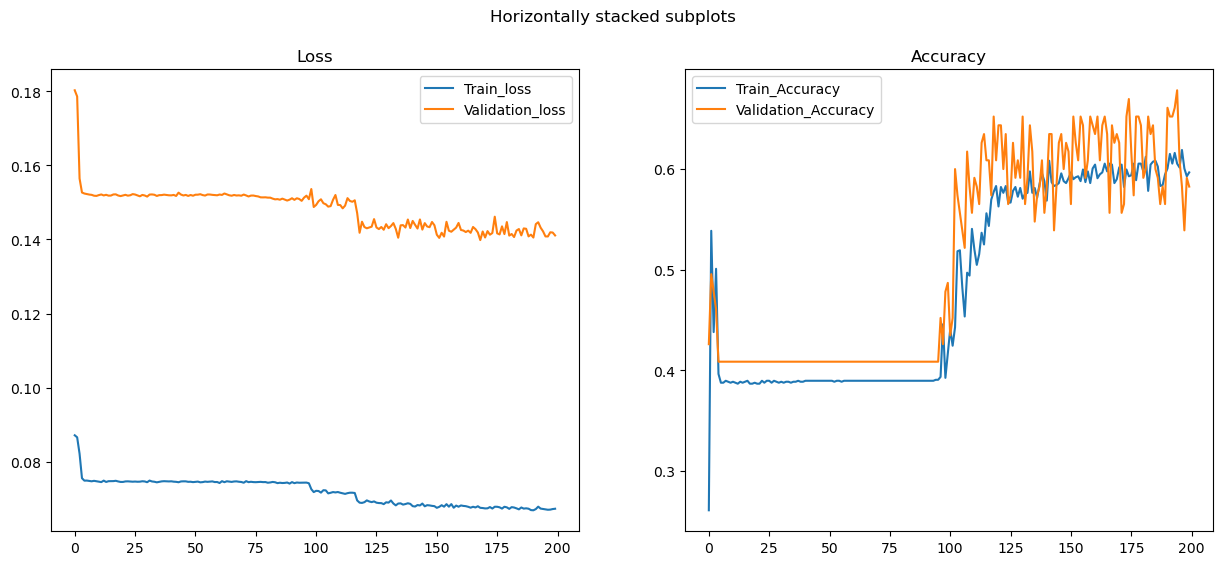

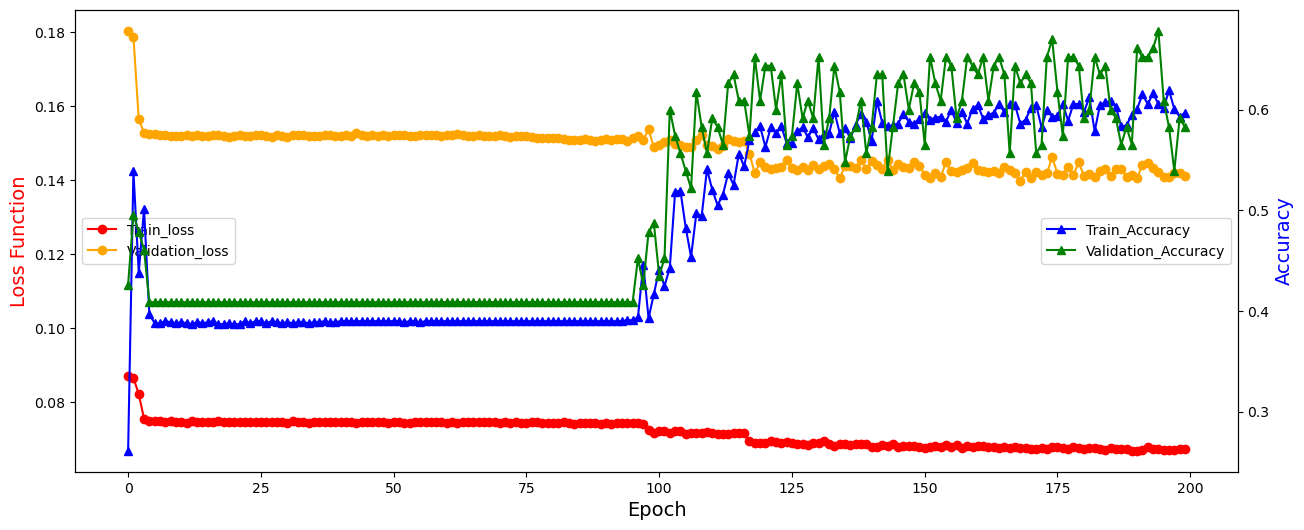

Current time: 34.478 minutes. Time expected till completion: 51.717 minutes

Epoch 201 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.06708823758352195
Val loss:  0.14259931782017585
train accuracy:  0.6025145067698259
Val accuracy:  0.6347826086956522
Current time: 34.647 minutes. Time expected till completion: 51.539 minutes

Epoch 202 of 500


100%|██████████| 15/15 [00:00<00:00, 33.35it/s]


train loss:  0.06705146624456292
Val loss:  0.14215230734451959
train accuracy:  0.5947775628626693
Val accuracy:  0.6521739130434783
Current time: 34.816 minutes. Time expected till completion: 51.363 minutes

Epoch 203 of 500


100%|██████████| 15/15 [00:00<00:00, 33.13it/s]


train loss:  0.06692463344024274
Val loss:  0.1440366947132608
train accuracy:  0.6131528046421664
Val accuracy:  0.6521739130434783
Current time: 34.989 minutes. Time expected till completion: 51.191 minutes

Epoch 204 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.0671532600253417
Val loss:  0.1422098678091298
train accuracy:  0.5957446808510638
Val accuracy:  0.6695652173913044
Current time: 35.156 minutes. Time expected till completion: 51.011 minutes

Epoch 205 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06798099756702003
Val loss:  0.14089797320573227
train accuracy:  0.6092843326885881
Val accuracy:  0.6608695652173913
Current time: 35.326 minutes. Time expected till completion: 50.835 minutes

Epoch 206 of 500


100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


train loss:  0.06755736239643577
Val loss:  0.14226381467736285
train accuracy:  0.6073500967117988
Val accuracy:  0.6
Current time: 35.497 minutes. Time expected till completion: 50.660 minutes

Epoch 207 of 500


100%|██████████| 15/15 [00:00<00:00, 33.72it/s]


train loss:  0.06725285154707888
Val loss:  0.1435238252515378
train accuracy:  0.6083172147001934
Val accuracy:  0.6521739130434783
Current time: 35.665 minutes. Time expected till completion: 50.483 minutes

Epoch 208 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.0670271922818005
Val loss:  0.14421530599179475
train accuracy:  0.6150870406189555
Val accuracy:  0.6695652173913044
Current time: 35.837 minutes. Time expected till completion: 50.310 minutes

Epoch 209 of 500


100%|██████████| 15/15 [00:00<00:00, 32.84it/s]


train loss:  0.06704683495213493
Val loss:  0.14288288147553155
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 36.008 minutes. Time expected till completion: 50.135 minutes

Epoch 210 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.06780222680859224
Val loss:  0.14259092289468517
train accuracy:  0.6092843326885881
Val accuracy:  0.6521739130434783
Current time: 36.176 minutes. Time expected till completion: 49.957 minutes

Epoch 211 of 500


100%|██████████| 15/15 [00:00<00:00, 31.86it/s]


train loss:  0.06765580119662405
Val loss:  0.1406321442645529
train accuracy:  0.6102514506769826
Val accuracy:  0.6260869565217392
Current time: 36.348 minutes. Time expected till completion: 49.785 minutes

Epoch 212 of 500


100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


train loss:  0.06693831933536197
Val loss:  0.14045430888300356
train accuracy:  0.5918762088974855
Val accuracy:  0.6086956521739131
Current time: 36.519 minutes. Time expected till completion: 49.611 minutes

Epoch 213 of 500


100%|██████████| 15/15 [00:00<00:00, 33.20it/s]


train loss:  0.06748753607388391
Val loss:  0.14113216866617617
train accuracy:  0.6054158607350096
Val accuracy:  0.6695652173913044
Current time: 36.687 minutes. Time expected till completion: 49.433 minutes

Epoch 214 of 500


100%|██████████| 15/15 [00:00<00:00, 33.72it/s]


train loss:  0.0671580548558521
Val loss:  0.14032787602880728
train accuracy:  0.6121856866537717
Val accuracy:  0.6347826086956522
Current time: 36.860 minutes. Time expected till completion: 49.262 minutes

Epoch 215 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06655079126358032
Val loss:  0.14342329968576845
train accuracy:  0.5996131528046421
Val accuracy:  0.6695652173913044
Current time: 37.030 minutes. Time expected till completion: 49.086 minutes

Epoch 216 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.0674505908207921
Val loss:  0.14062450450399647
train accuracy:  0.6141199226305609
Val accuracy:  0.6086956521739131
Current time: 37.200 minutes. Time expected till completion: 48.911 minutes

Epoch 217 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.0674053451885799
Val loss:  0.14178468921910162
train accuracy:  0.5967117988394585
Val accuracy:  0.6608695652173913
Current time: 37.372 minutes. Time expected till completion: 48.739 minutes

Epoch 218 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06704818597153492
Val loss:  0.1412432945292929
train accuracy:  0.5957446808510638
Val accuracy:  0.6173913043478261
Current time: 37.542 minutes. Time expected till completion: 48.564 minutes

Epoch 219 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06680487594936525
Val loss:  0.1409414908160334
train accuracy:  0.6121856866537717
Val accuracy:  0.6521739130434783
Current time: 37.717 minutes. Time expected till completion: 48.395 minutes

Epoch 220 of 500


100%|██████████| 15/15 [00:00<00:00, 30.02it/s]


train loss:  0.06721188499803007
Val loss:  0.14072978755702142
train accuracy:  0.6063829787234043
Val accuracy:  0.6608695652173913
Current time: 37.891 minutes. Time expected till completion: 48.224 minutes

Epoch 221 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.06695574965882808
Val loss:  0.14154044959856116
train accuracy:  0.6102514506769826
Val accuracy:  0.6608695652173913
Current time: 38.061 minutes. Time expected till completion: 48.050 minutes

Epoch 222 of 500


100%|██████████| 15/15 [00:00<00:00, 30.57it/s]


train loss:  0.06716642717558825
Val loss:  0.140340182573899
train accuracy:  0.6199226305609284
Val accuracy:  0.6173913043478261
Current time: 38.234 minutes. Time expected till completion: 47.879 minutes

Epoch 223 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.06723334641705629
Val loss:  0.14293701959692914
train accuracy:  0.6083172147001934
Val accuracy:  0.6347826086956522
Current time: 38.405 minutes. Time expected till completion: 47.704 minutes

Epoch 224 of 500


100%|██████████| 15/15 [00:00<00:00, 32.55it/s]


train loss:  0.06728858407046394
Val loss:  0.14054926633834838
train accuracy:  0.6083172147001934
Val accuracy:  0.6608695652173913
Current time: 38.572 minutes. Time expected till completion: 47.526 minutes

Epoch 225 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06716112968308321
Val loss:  0.141741537011188
train accuracy:  0.6160541586073501
Val accuracy:  0.5565217391304348
Current time: 38.743 minutes. Time expected till completion: 47.352 minutes

Epoch 226 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.06704642515579091
Val loss:  0.14083581903706427
train accuracy:  0.6141199226305609
Val accuracy:  0.6434782608695652
Current time: 38.912 minutes. Time expected till completion: 47.176 minutes

Epoch 227 of 500


100%|██████████| 15/15 [00:00<00:00, 32.48it/s]


train loss:  0.0670951891913866
Val loss:  0.1424958902856578
train accuracy:  0.597678916827853
Val accuracy:  0.6695652173913044
Current time: 39.081 minutes. Time expected till completion: 47.001 minutes

Epoch 228 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.06732429653348498
Val loss:  0.14216653575067933
train accuracy:  0.6121856866537717
Val accuracy:  0.6695652173913044
Current time: 39.254 minutes. Time expected till completion: 46.829 minutes

Epoch 229 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06686273747532695
Val loss:  0.13954422214756843
train accuracy:  0.6025145067698259
Val accuracy:  0.6086956521739131
Current time: 39.424 minutes. Time expected till completion: 46.654 minutes

Epoch 230 of 500


100%|██████████| 15/15 [00:00<00:00, 33.72it/s]


train loss:  0.06777930634395297
Val loss:  0.1410155177116394
train accuracy:  0.6112185686653772
Val accuracy:  0.6521739130434783
Current time: 39.596 minutes. Time expected till completion: 46.483 minutes

Epoch 231 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06692205170598205
Val loss:  0.14032774334368497
train accuracy:  0.6112185686653772
Val accuracy:  0.6434782608695652
Current time: 39.767 minutes. Time expected till completion: 46.309 minutes

Epoch 232 of 500


100%|██████████| 15/15 [00:00<00:00, 32.84it/s]


train loss:  0.06693301267734579
Val loss:  0.13980330021485038
train accuracy:  0.6179883945841392
Val accuracy:  0.6434782608695652
Current time: 39.934 minutes. Time expected till completion: 46.130 minutes

Epoch 233 of 500


100%|██████████| 15/15 [00:00<00:00, 31.86it/s]


train loss:  0.06692564527808582
Val loss:  0.13946352315985638
train accuracy:  0.6170212765957447
Val accuracy:  0.6260869565217392
Current time: 40.104 minutes. Time expected till completion: 45.957 minutes

Epoch 234 of 500


100%|██████████| 15/15 [00:00<00:00, 33.87it/s]


train loss:  0.06676463312982821
Val loss:  0.14269299196160357
train accuracy:  0.6092843326885881
Val accuracy:  0.6782608695652174
Current time: 40.277 minutes. Time expected till completion: 45.785 minutes

Epoch 235 of 500


100%|██████████| 15/15 [00:00<00:00, 33.06it/s]


train loss:  0.06706491516222114
Val loss:  0.14144703149795532
train accuracy:  0.6170212765957447
Val accuracy:  0.6695652173913044
Current time: 40.445 minutes. Time expected till completion: 45.608 minutes

Epoch 236 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06671571039830693
Val loss:  0.14387474163718847
train accuracy:  0.6179883945841392
Val accuracy:  0.6608695652173913
Current time: 40.616 minutes. Time expected till completion: 45.434 minutes

Epoch 237 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06701948558569415
Val loss:  0.14325420027193816
train accuracy:  0.6170212765957447
Val accuracy:  0.6608695652173913
Current time: 40.788 minutes. Time expected till completion: 45.262 minutes

Epoch 238 of 500


100%|██████████| 15/15 [00:00<00:00, 31.20it/s]


train loss:  0.06715135919056271
Val loss:  0.1400900934053504
train accuracy:  0.6189555125725339
Val accuracy:  0.6434782608695652
Current time: 40.955 minutes. Time expected till completion: 45.085 minutes

Epoch 239 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.0668419398929441
Val loss:  0.14510851217352827
train accuracy:  0.6150870406189555
Val accuracy:  0.6608695652173913
Current time: 41.125 minutes. Time expected till completion: 44.911 minutes

Epoch 240 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.06696694524421913
Val loss:  0.14334429139676302
train accuracy:  0.6160541586073501
Val accuracy:  0.6260869565217392
Current time: 41.293 minutes. Time expected till completion: 44.734 minutes

Epoch 241 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.0672111497395735
Val loss:  0.1427526655404464
train accuracy:  0.6025145067698259
Val accuracy:  0.6173913043478261
Current time: 41.465 minutes. Time expected till completion: 44.562 minutes

Epoch 242 of 500


100%|██████████| 15/15 [00:00<00:00, 32.84it/s]


train loss:  0.06680968530634616
Val loss:  0.1433363194050996
train accuracy:  0.6170212765957447
Val accuracy:  0.6521739130434783
Current time: 41.634 minutes. Time expected till completion: 44.387 minutes

Epoch 243 of 500


100%|██████████| 15/15 [00:00<00:00, 32.62it/s]


train loss:  0.06684779411819503
Val loss:  0.1407641229422196
train accuracy:  0.6179883945841392
Val accuracy:  0.6434782608695652
Current time: 41.802 minutes. Time expected till completion: 44.210 minutes

Epoch 244 of 500


100%|██████████| 15/15 [00:00<00:00, 33.80it/s]


train loss:  0.06704542225288007
Val loss:  0.1438925344011058
train accuracy:  0.6102514506769826
Val accuracy:  0.6608695652173913
Current time: 41.971 minutes. Time expected till completion: 44.035 minutes

Epoch 245 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.06664229793982072
Val loss:  0.14419822848361472
train accuracy:  0.6179883945841392
Val accuracy:  0.6608695652173913
Current time: 42.141 minutes. Time expected till completion: 43.861 minutes

Epoch 246 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.0667911203041298
Val loss:  0.1412799166596454
train accuracy:  0.6092843326885881
Val accuracy:  0.6347826086956522
Current time: 42.310 minutes. Time expected till completion: 43.686 minutes

Epoch 247 of 500


100%|██████████| 15/15 [00:00<00:00, 32.48it/s]


train loss:  0.066832277772505
Val loss:  0.14211084324380627
train accuracy:  0.6131528046421664
Val accuracy:  0.6521739130434783
Current time: 42.481 minutes. Time expected till completion: 43.513 minutes

Epoch 248 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06716805316032247
Val loss:  0.14476607986118484
train accuracy:  0.6083172147001934
Val accuracy:  0.6695652173913044
Current time: 42.651 minutes. Time expected till completion: 43.339 minutes

Epoch 249 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.06629364472062721
Val loss:  0.14237230808838555
train accuracy:  0.6189555125725339
Val accuracy:  0.6347826086956522
Current time: 42.823 minutes. Time expected till completion: 43.167 minutes

Epoch 250 of 500


100%|██████████| 15/15 [00:00<00:00, 32.21it/s]


train loss:  0.06668734879051001
Val loss:  0.14457774110462354
train accuracy:  0.5996131528046421
Val accuracy:  0.6608695652173913
Current time: 42.994 minutes. Time expected till completion: 42.994 minutes

Epoch 251 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06684581125497358
Val loss:  0.14203515467436417
train accuracy:  0.6112185686653772
Val accuracy:  0.6608695652173913
Current time: 43.161 minutes. Time expected till completion: 42.817 minutes

Epoch 252 of 500


100%|██████████| 15/15 [00:00<00:00, 33.72it/s]


train loss:  0.06638003882863766
Val loss:  0.1424075131830962
train accuracy:  0.6112185686653772
Val accuracy:  0.6695652173913044
Current time: 43.331 minutes. Time expected till completion: 42.643 minutes

Epoch 253 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.06686828825874992
Val loss:  0.1443126652551734
train accuracy:  0.6131528046421664
Val accuracy:  0.6608695652173913
Current time: 43.500 minutes. Time expected till completion: 42.468 minutes

Epoch 254 of 500


100%|██████████| 15/15 [00:00<00:00, 32.41it/s]


train loss:  0.0674350645025648
Val loss:  0.1422930385755456
train accuracy:  0.6179883945841392
Val accuracy:  0.6347826086956522
Current time: 43.666 minutes. Time expected till completion: 42.290 minutes

Epoch 255 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06707220012952557
Val loss:  0.14323250832765
train accuracy:  0.6160541586073501
Val accuracy:  0.6782608695652174
Current time: 43.833 minutes. Time expected till completion: 42.114 minutes

Epoch 256 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.06669204055225365
Val loss:  0.1432863800422005
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 44.004 minutes. Time expected till completion: 41.941 minutes

Epoch 257 of 500


100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


train loss:  0.0668686660046273
Val loss:  0.1431737967159437
train accuracy:  0.6218568665377177
Val accuracy:  0.6260869565217392
Current time: 44.170 minutes. Time expected till completion: 41.764 minutes

Epoch 258 of 500


100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


train loss:  0.06651765972779383
Val loss:  0.14334481591763704
train accuracy:  0.6228239845261122
Val accuracy:  0.6695652173913044
Current time: 44.338 minutes. Time expected till completion: 41.588 minutes

Epoch 259 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.06645566184700573
Val loss:  0.1425504523774852
train accuracy:  0.6247582205029013
Val accuracy:  0.6782608695652174
Current time: 44.505 minutes. Time expected till completion: 41.412 minutes

Epoch 260 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06683000662801805
Val loss:  0.14186422617539116
train accuracy:  0.620889748549323
Val accuracy:  0.6
Current time: 44.675 minutes. Time expected till completion: 41.238 minutes

Epoch 261 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06675238869868118
Val loss:  0.14317137624906456
train accuracy:  0.6150870406189555
Val accuracy:  0.6782608695652174
Current time: 44.844 minutes. Time expected till completion: 41.064 minutes

Epoch 262 of 500


100%|██████████| 15/15 [00:00<00:00, 29.96it/s]


train loss:  0.06688764293604248
Val loss:  0.1440168339273204
train accuracy:  0.6121856866537717
Val accuracy:  0.6173913043478261
Current time: 45.013 minutes. Time expected till completion: 40.890 minutes

Epoch 263 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.06694305346597786
Val loss:  0.14197846754737523
train accuracy:  0.6170212765957447
Val accuracy:  0.6695652173913044
Current time: 45.183 minutes. Time expected till completion: 40.716 minutes

Epoch 264 of 500


100%|██████████| 15/15 [00:00<00:00, 33.42it/s]


train loss:  0.06626905982222271
Val loss:  0.14308277005734651
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 45.352 minutes. Time expected till completion: 40.542 minutes

Epoch 265 of 500


100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


train loss:  0.06645872358888445
Val loss:  0.14226267182308694
train accuracy:  0.6247582205029013
Val accuracy:  0.591304347826087
Current time: 45.523 minutes. Time expected till completion: 40.369 minutes

Epoch 266 of 500


100%|██████████| 15/15 [00:00<00:00, 33.65it/s]


train loss:  0.06710623224883752
Val loss:  0.14362071804378343
train accuracy:  0.6170212765957447
Val accuracy:  0.6782608695652174
Current time: 45.695 minutes. Time expected till completion: 40.198 minutes

Epoch 267 of 500


100%|██████████| 15/15 [00:00<00:00, 29.20it/s]


train loss:  0.06699436747359122
Val loss:  0.14242185924364173
train accuracy:  0.6092843326885881
Val accuracy:  0.6086956521739131
Current time: 45.865 minutes. Time expected till completion: 40.025 minutes

Epoch 268 of 500


100%|██████████| 15/15 [00:00<00:00, 33.95it/s]


train loss:  0.06667834018830866
Val loss:  0.1423742677854455
train accuracy:  0.6073500967117988
Val accuracy:  0.6434782608695652
Current time: 46.033 minutes. Time expected till completion: 39.850 minutes

Epoch 269 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06685271052142869
Val loss:  0.1430045019025388
train accuracy:  0.6170212765957447
Val accuracy:  0.6521739130434783
Current time: 46.204 minutes. Time expected till completion: 39.677 minutes

Epoch 270 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06695283496864068
Val loss:  0.1417992483014646
train accuracy:  0.6063829787234043
Val accuracy:  0.6608695652173913
Current time: 46.373 minutes. Time expected till completion: 39.503 minutes

Epoch 271 of 500


100%|██████████| 15/15 [00:00<00:00, 32.34it/s]


train loss:  0.06714572730101284
Val loss:  0.1407192385714987
train accuracy:  0.6121856866537717
Val accuracy:  0.6347826086956522
Current time: 46.541 minutes. Time expected till completion: 39.328 minutes

Epoch 272 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.0665453589977102
Val loss:  0.14110417832498964
train accuracy:  0.6170212765957447
Val accuracy:  0.6695652173913044
Current time: 46.712 minutes. Time expected till completion: 39.155 minutes

Epoch 273 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.0668384386100437
Val loss:  0.14181652587393057
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 46.879 minutes. Time expected till completion: 38.980 minutes

Epoch 274 of 500


100%|██████████| 15/15 [00:00<00:00, 33.20it/s]


train loss:  0.06646969695386389
Val loss:  0.1412867141806561
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 47.051 minutes. Time expected till completion: 38.809 minutes

Epoch 275 of 500


100%|██████████| 15/15 [00:00<00:00, 30.95it/s]


train loss:  0.06626784294209581
Val loss:  0.14048569461573726
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 47.220 minutes. Time expected till completion: 38.635 minutes

Epoch 276 of 500


100%|██████████| 15/15 [00:00<00:00, 33.72it/s]


train loss:  0.06707753163241786
Val loss:  0.14012793147045632
train accuracy:  0.6141199226305609
Val accuracy:  0.6347826086956522
Current time: 47.386 minutes. Time expected till completion: 38.458 minutes

Epoch 277 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.06650644119980256
Val loss:  0.14174902801928313
train accuracy:  0.6160541586073501
Val accuracy:  0.5826086956521739
Current time: 47.555 minutes. Time expected till completion: 38.284 minutes

Epoch 278 of 500


100%|██████████| 15/15 [00:00<00:00, 32.21it/s]


train loss:  0.06684352575695031
Val loss:  0.14191113192102184
train accuracy:  0.6150870406189555
Val accuracy:  0.6347826086956522
Current time: 47.725 minutes. Time expected till completion: 38.111 minutes

Epoch 279 of 500


100%|██████████| 15/15 [00:00<00:00, 32.07it/s]


train loss:  0.06642979821568532
Val loss:  0.14185729752416196
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 47.891 minutes. Time expected till completion: 37.935 minutes

Epoch 280 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.06632442959733811
Val loss:  0.14024628763613495
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 48.061 minutes. Time expected till completion: 37.762 minutes

Epoch 281 of 500


100%|██████████| 15/15 [00:00<00:00, 32.34it/s]


train loss:  0.06636362091946187
Val loss:  0.1414418795834417
train accuracy:  0.6286266924564797
Val accuracy:  0.6782608695652174
Current time: 48.227 minutes. Time expected till completion: 37.586 minutes

Epoch 282 of 500


100%|██████████| 15/15 [00:00<00:00, 33.95it/s]


train loss:  0.06671055229074489
Val loss:  0.14055026199506676
train accuracy:  0.6228239845261122
Val accuracy:  0.6695652173913044
Current time: 48.392 minutes. Time expected till completion: 37.410 minutes

Epoch 283 of 500


100%|██████████| 15/15 [00:00<00:00, 32.62it/s]


train loss:  0.06687041275505863
Val loss:  0.14080028533935546
train accuracy:  0.6295938104448743
Val accuracy:  0.6695652173913044
Current time: 48.563 minutes. Time expected till completion: 37.237 minutes

Epoch 284 of 500


100%|██████████| 15/15 [00:00<00:00, 33.65it/s]


train loss:  0.06658632669965349
Val loss:  0.1432074583095053
train accuracy:  0.6141199226305609
Val accuracy:  0.6695652173913044
Current time: 48.730 minutes. Time expected till completion: 37.062 minutes

Epoch 285 of 500


100%|██████████| 15/15 [00:00<00:00, 34.18it/s]


train loss:  0.06629219530168308
Val loss:  0.14257360904113106
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 48.897 minutes. Time expected till completion: 36.888 minutes

Epoch 286 of 500


100%|██████████| 15/15 [00:00<00:00, 32.07it/s]


train loss:  0.0661071558524377
Val loss:  0.14120238604752913
train accuracy:  0.6092843326885881
Val accuracy:  0.6260869565217392
Current time: 49.066 minutes. Time expected till completion: 36.714 minutes

Epoch 287 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.06690805308823429
Val loss:  0.14140821436177128
train accuracy:  0.6063829787234043
Val accuracy:  0.6434782608695652
Current time: 49.231 minutes. Time expected till completion: 36.537 minutes

Epoch 288 of 500


100%|██████████| 15/15 [00:00<00:00, 33.27it/s]


train loss:  0.06720907395305671
Val loss:  0.1457287109416464
train accuracy:  0.6054158607350096
Val accuracy:  0.6521739130434783
Current time: 49.397 minutes. Time expected till completion: 36.362 minutes

Epoch 289 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06669861925639774
Val loss:  0.14193842100060505
train accuracy:  0.625725338491296
Val accuracy:  0.6782608695652174
Current time: 49.564 minutes. Time expected till completion: 36.187 minutes

Epoch 290 of 500


100%|██████████| 15/15 [00:00<00:00, 33.72it/s]


train loss:  0.06660894545180654
Val loss:  0.14222146635470184
train accuracy:  0.6160541586073501
Val accuracy:  0.6695652173913044
Current time: 49.730 minutes. Time expected till completion: 36.011 minutes

Epoch 291 of 500


100%|██████████| 15/15 [00:00<00:00, 32.98it/s]


train loss:  0.06645805133611137
Val loss:  0.14169229631838592
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 49.901 minutes. Time expected till completion: 35.840 minutes

Epoch 292 of 500


100%|██████████| 15/15 [00:00<00:00, 33.57it/s]


train loss:  0.06618618676925304
Val loss:  0.14318223517874012
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 50.067 minutes. Time expected till completion: 35.664 minutes

Epoch 293 of 500


100%|██████████| 15/15 [00:00<00:00, 33.20it/s]


train loss:  0.06698362601333707
Val loss:  0.1434329603029334
train accuracy:  0.6189555125725339
Val accuracy:  0.6782608695652174
Current time: 50.237 minutes. Time expected till completion: 35.491 minutes

Epoch 294 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.06669950358411099
Val loss:  0.14214375019073486
train accuracy:  0.6073500967117988
Val accuracy:  0.6434782608695652
Current time: 50.405 minutes. Time expected till completion: 35.318 minutes

Epoch 295 of 500


100%|██████████| 15/15 [00:00<00:00, 32.91it/s]


train loss:  0.06617323705490599
Val loss:  0.14073713603227034
train accuracy:  0.632495164410058
Val accuracy:  0.6434782608695652
Current time: 50.571 minutes. Time expected till completion: 35.142 minutes

Epoch 296 of 500


100%|██████████| 15/15 [00:00<00:00, 32.07it/s]


train loss:  0.06695261580339945
Val loss:  0.14187842400177667
train accuracy:  0.6141199226305609
Val accuracy:  0.6521739130434783
Current time: 50.740 minutes. Time expected till completion: 34.969 minutes

Epoch 297 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06658324645381831
Val loss:  0.1399175991182742
train accuracy:  0.6131528046421664
Val accuracy:  0.6782608695652174
Current time: 50.908 minutes. Time expected till completion: 34.796 minutes

Epoch 298 of 500


100%|██████████| 15/15 [00:00<00:00, 32.91it/s]


train loss:  0.06598489023961228
Val loss:  0.14222989496977434
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 51.076 minutes. Time expected till completion: 34.622 minutes

Epoch 299 of 500


100%|██████████| 15/15 [00:00<00:00, 32.55it/s]


train loss:  0.0659290162460947
Val loss:  0.14100239587866742
train accuracy:  0.6189555125725339
Val accuracy:  0.6695652173913044
Current time: 51.245 minutes. Time expected till completion: 34.449 minutes

Epoch 300 of 500


100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


train loss:  0.06659423394175516
Val loss:  0.14015210659607596
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Saving model checkpoint


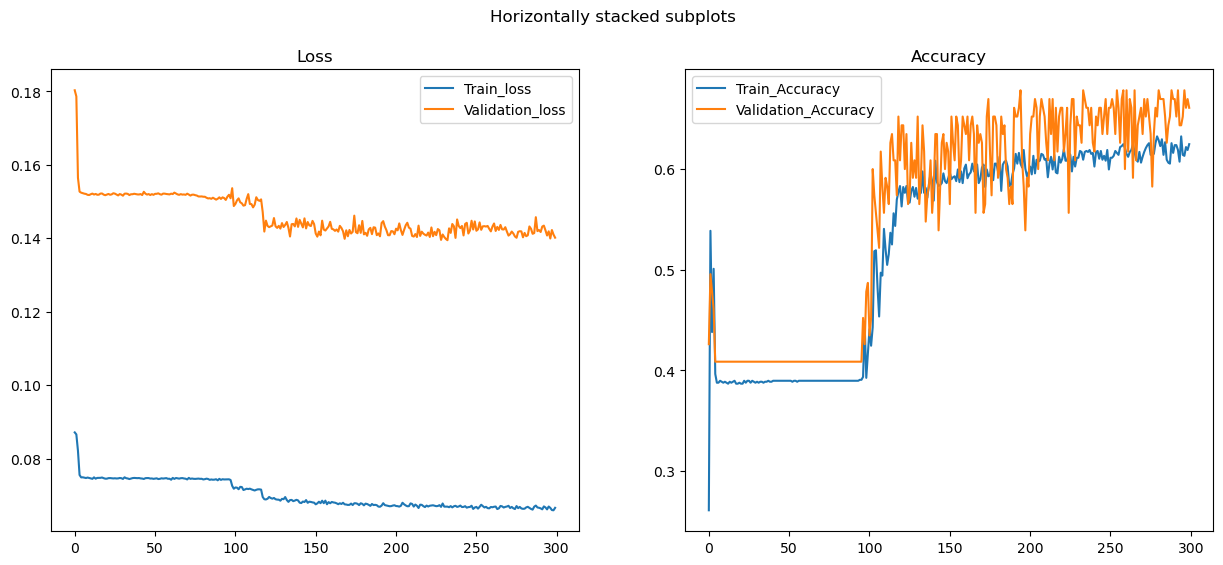

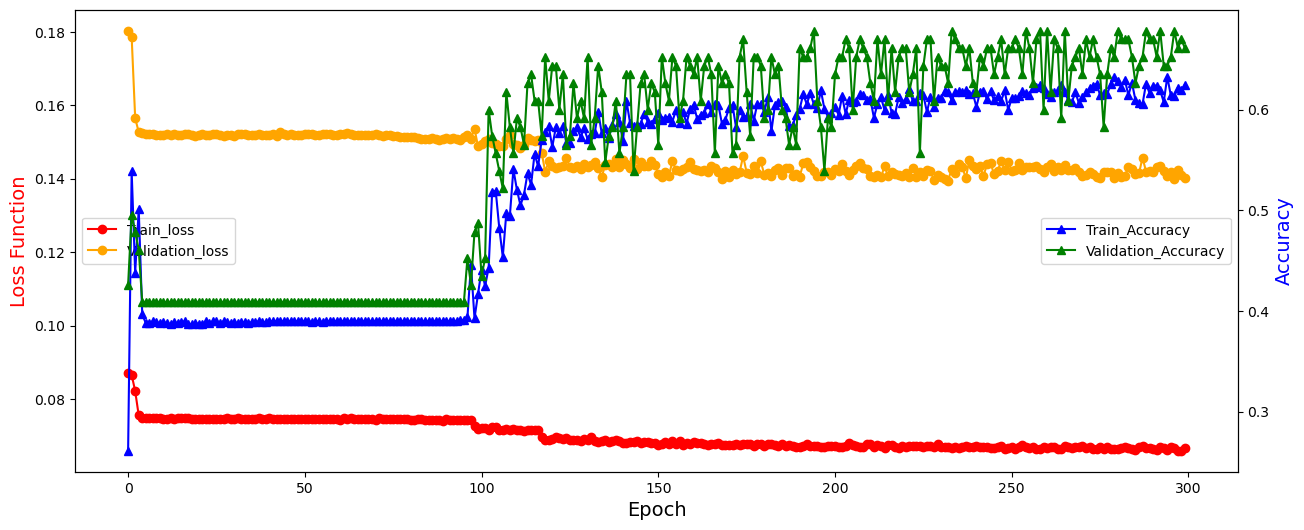

Current time: 51.426 minutes. Time expected till completion: 34.284 minutes

Epoch 301 of 500


100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


train loss:  0.06633867003470371
Val loss:  0.1409418655478436
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 51.598 minutes. Time expected till completion: 34.113 minutes

Epoch 302 of 500


100%|██████████| 15/15 [00:00<00:00, 32.48it/s]


train loss:  0.06633256678424444
Val loss:  0.13980673603389573
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 51.768 minutes. Time expected till completion: 33.940 minutes

Epoch 303 of 500


100%|██████████| 15/15 [00:00<00:00, 32.62it/s]


train loss:  0.06688987586207731
Val loss:  0.13967875086742898
train accuracy:  0.6112185686653772
Val accuracy:  0.6608695652173913
Current time: 51.935 minutes. Time expected till completion: 33.767 minutes

Epoch 304 of 500


100%|██████████| 15/15 [00:00<00:00, 32.91it/s]


train loss:  0.0667245822672226
Val loss:  0.14147800258968188
train accuracy:  0.6189555125725339
Val accuracy:  0.6173913043478261
Current time: 52.105 minutes. Time expected till completion: 33.594 minutes

Epoch 305 of 500


100%|██████████| 15/15 [00:00<00:00, 30.57it/s]


train loss:  0.06649079088777361
Val loss:  0.14063297043675962
train accuracy:  0.6179883945841392
Val accuracy:  0.6695652173913044
Current time: 52.278 minutes. Time expected till completion: 33.424 minutes

Epoch 306 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06610639528794722
Val loss:  0.13956393262614375
train accuracy:  0.6160541586073501
Val accuracy:  0.6695652173913044
Current time: 52.448 minutes. Time expected till completion: 33.251 minutes

Epoch 307 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06667234992150874
Val loss:  0.1405447508977807
train accuracy:  0.6228239845261122
Val accuracy:  0.6695652173913044
Current time: 52.620 minutes. Time expected till completion: 33.080 minutes

Epoch 308 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06618241645842503
Val loss:  0.13940410717673923
train accuracy:  0.6150870406189555
Val accuracy:  0.6782608695652174
Current time: 52.789 minutes. Time expected till completion: 32.908 minutes

Epoch 309 of 500


100%|██████████| 15/15 [00:00<00:00, 32.07it/s]


train loss:  0.06672361666044829
Val loss:  0.14057087017142256
train accuracy:  0.6160541586073501
Val accuracy:  0.6347826086956522
Current time: 52.961 minutes. Time expected till completion: 32.736 minutes

Epoch 310 of 500


100%|██████████| 15/15 [00:00<00:00, 32.77it/s]


train loss:  0.06653824719515714
Val loss:  0.14124575490536898
train accuracy:  0.6218568665377177
Val accuracy:  0.6695652173913044
Current time: 53.132 minutes. Time expected till completion: 32.565 minutes

Epoch 311 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.06644908913791295
Val loss:  0.14408446602199387
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 53.305 minutes. Time expected till completion: 32.394 minutes

Epoch 312 of 500


100%|██████████| 15/15 [00:00<00:00, 33.80it/s]


train loss:  0.0665085060914665
Val loss:  0.1412941751272782
train accuracy:  0.6150870406189555
Val accuracy:  0.6782608695652174
Current time: 53.477 minutes. Time expected till completion: 32.224 minutes

Epoch 313 of 500


100%|██████████| 15/15 [00:00<00:00, 33.72it/s]


train loss:  0.06659031513811772
Val loss:  0.14183289019957832
train accuracy:  0.6218568665377177
Val accuracy:  0.6695652173913044
Current time: 53.648 minutes. Time expected till completion: 32.051 minutes

Epoch 314 of 500


100%|██████████| 15/15 [00:00<00:00, 30.14it/s]


train loss:  0.06710105356210896
Val loss:  0.14049130730007006
train accuracy:  0.6160541586073501
Val accuracy:  0.6260869565217392
Current time: 53.817 minutes. Time expected till completion: 31.879 minutes

Epoch 315 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.0664897610647766
Val loss:  0.1402064499647721
train accuracy:  0.6121856866537717
Val accuracy:  0.6521739130434783
Current time: 53.987 minutes. Time expected till completion: 31.706 minutes

Epoch 316 of 500


100%|██████████| 15/15 [00:00<00:00, 32.34it/s]


train loss:  0.06631145596043053
Val loss:  0.14101059229477592
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 54.161 minutes. Time expected till completion: 31.537 minutes

Epoch 317 of 500


100%|██████████| 15/15 [00:00<00:00, 31.07it/s]


train loss:  0.06694931737228335
Val loss:  0.14036061919253806
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 54.328 minutes. Time expected till completion: 31.363 minutes

Epoch 318 of 500


100%|██████████| 15/15 [00:00<00:00, 33.50it/s]


train loss:  0.06629685380242088
Val loss:  0.14046433386595353
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 54.501 minutes. Time expected till completion: 31.192 minutes

Epoch 319 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06660413396197085
Val loss:  0.13971403163412344
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 54.672 minutes. Time expected till completion: 31.021 minutes

Epoch 320 of 500


100%|██████████| 15/15 [00:00<00:00, 33.72it/s]


train loss:  0.06647968828332262
Val loss:  0.13951878599498582
train accuracy:  0.6179883945841392
Val accuracy:  0.6608695652173913
Current time: 54.838 minutes. Time expected till completion: 30.846 minutes

Epoch 321 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06600120346596901
Val loss:  0.14087535868520323
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 55.012 minutes. Time expected till completion: 30.676 minutes

Epoch 322 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06687050354549917
Val loss:  0.14219583583914716
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 55.181 minutes. Time expected till completion: 30.504 minutes

Epoch 323 of 500


100%|██████████| 15/15 [00:00<00:00, 33.20it/s]


train loss:  0.06606220172959555
Val loss:  0.14296086197314056
train accuracy:  0.6228239845261122
Val accuracy:  0.6695652173913044
Current time: 55.350 minutes. Time expected till completion: 30.331 minutes

Epoch 324 of 500


100%|██████████| 15/15 [00:00<00:00, 32.55it/s]


train loss:  0.06608741991293961
Val loss:  0.14626660502475242
train accuracy:  0.6170212765957447
Val accuracy:  0.6434782608695652
Current time: 55.519 minutes. Time expected till completion: 30.158 minutes

Epoch 325 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.06696355475447856
Val loss:  0.141948780287867
train accuracy:  0.6199226305609284
Val accuracy:  0.6695652173913044
Current time: 55.691 minutes. Time expected till completion: 29.987 minutes

Epoch 326 of 500


100%|██████████| 15/15 [00:00<00:00, 33.20it/s]


train loss:  0.0663532140291867
Val loss:  0.14151595364446226
train accuracy:  0.6150870406189555
Val accuracy:  0.6695652173913044
Current time: 55.861 minutes. Time expected till completion: 29.815 minutes

Epoch 327 of 500


100%|██████████| 15/15 [00:00<00:00, 33.57it/s]


train loss:  0.06626539990104144
Val loss:  0.14263082172559655
train accuracy:  0.6276595744680851
Val accuracy:  0.6782608695652174
Current time: 56.032 minutes. Time expected till completion: 29.644 minutes

Epoch 328 of 500


100%|██████████| 15/15 [00:00<00:00, 32.21it/s]


train loss:  0.06607069083754283
Val loss:  0.14081006568411122
train accuracy:  0.6199226305609284
Val accuracy:  0.6782608695652174
Current time: 56.198 minutes. Time expected till completion: 29.470 minutes

Epoch 329 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06620393990317443
Val loss:  0.14177769992662512
train accuracy:  0.6305609284332688
Val accuracy:  0.6695652173913044
Current time: 56.366 minutes. Time expected till completion: 29.297 minutes

Epoch 330 of 500


100%|██████████| 15/15 [00:00<00:00, 31.07it/s]


train loss:  0.06618786982226418
Val loss:  0.14176870739978292
train accuracy:  0.6344294003868471
Val accuracy:  0.6695652173913044
Current time: 56.535 minutes. Time expected till completion: 29.124 minutes

Epoch 331 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06613529414457325
Val loss:  0.1432356466417727
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 56.702 minutes. Time expected till completion: 28.951 minutes

Epoch 332 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06618663662868035
Val loss:  0.14079555739527164
train accuracy:  0.6353965183752418
Val accuracy:  0.6695652173913044
Current time: 56.873 minutes. Time expected till completion: 28.779 minutes

Epoch 333 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06605036790181866
Val loss:  0.14066143606020057
train accuracy:  0.6353965183752418
Val accuracy:  0.6695652173913044
Current time: 57.039 minutes. Time expected till completion: 28.605 minutes

Epoch 334 of 500


100%|██████████| 15/15 [00:00<00:00, 32.55it/s]


train loss:  0.06589491212852228
Val loss:  0.13962985121685526
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 57.205 minutes. Time expected till completion: 28.431 minutes

Epoch 335 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.06619982228288337
Val loss:  0.14047979893891707
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 57.375 minutes. Time expected till completion: 28.259 minutes

Epoch 336 of 500


100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


train loss:  0.06629883118939353
Val loss:  0.13890855260517287
train accuracy:  0.6131528046421664
Val accuracy:  0.6695652173913044
Current time: 57.543 minutes. Time expected till completion: 28.086 minutes

Epoch 337 of 500


100%|██████████| 15/15 [00:00<00:00, 33.27it/s]


train loss:  0.06588127736427336
Val loss:  0.13943536748056826
train accuracy:  0.632495164410058
Val accuracy:  0.6434782608695652
Current time: 57.712 minutes. Time expected till completion: 27.914 minutes

Epoch 338 of 500


100%|██████████| 15/15 [00:00<00:00, 32.41it/s]


train loss:  0.06644776745967754
Val loss:  0.13847432032875392
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 57.879 minutes. Time expected till completion: 27.741 minutes

Epoch 339 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06617157717507398
Val loss:  0.14011134168376094
train accuracy:  0.6160541586073501
Val accuracy:  0.6521739130434783
Current time: 58.045 minutes. Time expected till completion: 27.567 minutes

Epoch 340 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.06607568955744259
Val loss:  0.14073365667591925
train accuracy:  0.6266924564796905
Val accuracy:  0.6695652173913044
Current time: 58.214 minutes. Time expected till completion: 27.395 minutes

Epoch 341 of 500


100%|██████████| 15/15 [00:00<00:00, 29.84it/s]


train loss:  0.06573758192173056
Val loss:  0.14289921884951384
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 58.381 minutes. Time expected till completion: 27.222 minutes

Epoch 342 of 500


100%|██████████| 15/15 [00:00<00:00, 32.21it/s]


train loss:  0.06604990172893443
Val loss:  0.14300797348437103
train accuracy:  0.6199226305609284
Val accuracy:  0.6434782608695652
Current time: 58.549 minutes. Time expected till completion: 27.049 minutes

Epoch 343 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06611225366361828
Val loss:  0.14085508222165316
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 58.718 minutes. Time expected till completion: 26.877 minutes

Epoch 344 of 500


100%|██████████| 15/15 [00:00<00:00, 33.27it/s]


train loss:  0.06580258268913401
Val loss:  0.14176798333292423
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 58.884 minutes. Time expected till completion: 26.703 minutes

Epoch 345 of 500


100%|██████████| 15/15 [00:00<00:00, 32.48it/s]


train loss:  0.0663419419492467
Val loss:  0.14246225253395411
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 59.051 minutes. Time expected till completion: 26.530 minutes

Epoch 346 of 500


100%|██████████| 15/15 [00:00<00:00, 32.98it/s]


train loss:  0.06624474573873229
Val loss:  0.14080555853636367
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 59.218 minutes. Time expected till completion: 26.357 minutes

Epoch 347 of 500


100%|██████████| 15/15 [00:00<00:00, 34.18it/s]


train loss:  0.06609128014953732
Val loss:  0.14155350612557452
train accuracy:  0.6189555125725339
Val accuracy:  0.6695652173913044
Current time: 59.385 minutes. Time expected till completion: 26.184 minutes

Epoch 348 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.0663209368458569
Val loss:  0.14074156439822652
train accuracy:  0.6131528046421664
Val accuracy:  0.6608695652173913
Current time: 59.553 minutes. Time expected till completion: 26.012 minutes

Epoch 349 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.06656543803860648
Val loss:  0.14170402962228526
train accuracy:  0.6276595744680851
Val accuracy:  0.6782608695652174
Current time: 59.721 minutes. Time expected till completion: 25.839 minutes

Epoch 350 of 500


100%|██████████| 15/15 [00:00<00:00, 32.62it/s]


train loss:  0.06589930799989682
Val loss:  0.14203940163487974
train accuracy:  0.6344294003868471
Val accuracy:  0.6434782608695652
Current time: 59.888 minutes. Time expected till completion: 25.666 minutes

Epoch 351 of 500


100%|██████████| 15/15 [00:00<00:00, 32.07it/s]


train loss:  0.0660860829588523
Val loss:  0.1416166383287181
train accuracy:  0.6131528046421664
Val accuracy:  0.6608695652173913
Current time: 60.057 minutes. Time expected till completion: 25.494 minutes

Epoch 352 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.06581447289345112
Val loss:  0.14146019583163055
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 60.223 minutes. Time expected till completion: 25.321 minutes

Epoch 353 of 500


100%|██████████| 15/15 [00:00<00:00, 33.57it/s]


train loss:  0.0666901610460226
Val loss:  0.14294330037158468
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 60.389 minutes. Time expected till completion: 25.148 minutes

Epoch 354 of 500


100%|██████████| 15/15 [00:00<00:00, 29.66it/s]


train loss:  0.06613884465606808
Val loss:  0.1417624727539394
train accuracy:  0.620889748549323
Val accuracy:  0.6695652173913044
Current time: 60.557 minutes. Time expected till completion: 24.976 minutes

Epoch 355 of 500


100%|██████████| 15/15 [00:00<00:00, 32.48it/s]


train loss:  0.06552046266469089
Val loss:  0.14090077306913293
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 60.723 minutes. Time expected till completion: 24.803 minutes

Epoch 356 of 500


100%|██████████| 15/15 [00:00<00:00, 30.82it/s]


train loss:  0.06643754947116343
Val loss:  0.14097890335580576
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 60.891 minutes. Time expected till completion: 24.630 minutes

Epoch 357 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06615058919216724
Val loss:  0.14013935586680537
train accuracy:  0.632495164410058
Val accuracy:  0.6695652173913044
Current time: 61.060 minutes. Time expected till completion: 24.458 minutes

Epoch 358 of 500


100%|██████████| 15/15 [00:00<00:00, 32.62it/s]


train loss:  0.06695480555353589
Val loss:  0.14139599022657975
train accuracy:  0.6131528046421664
Val accuracy:  0.6608695652173913
Current time: 61.231 minutes. Time expected till completion: 24.287 minutes

Epoch 359 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.0658851734558895
Val loss:  0.14044127827105315
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 61.402 minutes. Time expected till completion: 24.116 minutes

Epoch 360 of 500


100%|██████████| 15/15 [00:00<00:00, 29.78it/s]


train loss:  0.06585415142878343
Val loss:  0.14078746567601744
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 61.571 minutes. Time expected till completion: 23.944 minutes

Epoch 361 of 500


100%|██████████| 15/15 [00:00<00:00, 33.13it/s]


train loss:  0.06587896471558502
Val loss:  0.13983754593393077
train accuracy:  0.6112185686653772
Val accuracy:  0.6608695652173913
Current time: 61.737 minutes. Time expected till completion: 23.771 minutes

Epoch 362 of 500


100%|██████████| 15/15 [00:00<00:00, 31.86it/s]


train loss:  0.0659595555562807
Val loss:  0.14027047416438226
train accuracy:  0.6315280464216635
Val accuracy:  0.6782608695652174
Current time: 61.906 minutes. Time expected till completion: 23.599 minutes

Epoch 363 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06608935210644853
Val loss:  0.1407560680223548
train accuracy:  0.6141199226305609
Val accuracy:  0.6434782608695652
Current time: 62.073 minutes. Time expected till completion: 23.427 minutes

Epoch 364 of 500


100%|██████████| 15/15 [00:00<00:00, 33.06it/s]


train loss:  0.06611581714517605
Val loss:  0.14083337783813477
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 62.243 minutes. Time expected till completion: 23.256 minutes

Epoch 365 of 500


100%|██████████| 15/15 [00:00<00:00, 32.55it/s]


train loss:  0.0660416659695498
Val loss:  0.14315597855526468
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 62.416 minutes. Time expected till completion: 23.086 minutes

Epoch 366 of 500


100%|██████████| 15/15 [00:00<00:00, 33.57it/s]


train loss:  0.06573669321301827
Val loss:  0.14192823275275854
train accuracy:  0.6150870406189555
Val accuracy:  0.6608695652173913
Current time: 62.585 minutes. Time expected till completion: 22.914 minutes

Epoch 367 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06575428217476526
Val loss:  0.14202356234840724
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 62.757 minutes. Time expected till completion: 22.743 minutes

Epoch 368 of 500


100%|██████████| 15/15 [00:00<00:00, 32.41it/s]


train loss:  0.0659529577717329
Val loss:  0.14177063496216483
train accuracy:  0.6247582205029013
Val accuracy:  0.5739130434782609
Current time: 62.928 minutes. Time expected till completion: 22.572 minutes

Epoch 369 of 500


100%|██████████| 15/15 [00:00<00:00, 32.77it/s]


train loss:  0.06598132376052886
Val loss:  0.1409426678781924
train accuracy:  0.6305609284332688
Val accuracy:  0.6608695652173913
Current time: 63.097 minutes. Time expected till completion: 22.400 minutes

Epoch 370 of 500


100%|██████████| 15/15 [00:00<00:00, 33.42it/s]


train loss:  0.06567310145560731
Val loss:  0.14146640870882118
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 63.268 minutes. Time expected till completion: 22.229 minutes

Epoch 371 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.06535437616665543
Val loss:  0.14231358559235283
train accuracy:  0.6247582205029013
Val accuracy:  0.6347826086956522
Current time: 63.439 minutes. Time expected till completion: 22.058 minutes

Epoch 372 of 500


100%|██████████| 15/15 [00:00<00:00, 32.41it/s]


train loss:  0.06620007482441989
Val loss:  0.14387441873550416
train accuracy:  0.6237911025145068
Val accuracy:  0.6782608695652174
Current time: 63.609 minutes. Time expected till completion: 21.887 minutes

Epoch 373 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.06615581618517465
Val loss:  0.13910345046416572
train accuracy:  0.6112185686653772
Val accuracy:  0.6782608695652174
Current time: 63.782 minutes. Time expected till completion: 21.717 minutes

Epoch 374 of 500


100%|██████████| 15/15 [00:00<00:00, 30.76it/s]


train loss:  0.06583363175161572
Val loss:  0.14027402349140333
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 63.951 minutes. Time expected till completion: 21.545 minutes

Epoch 375 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.0655561332776422
Val loss:  0.14350702451623004
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 64.124 minutes. Time expected till completion: 21.375 minutes

Epoch 376 of 500


100%|██████████| 15/15 [00:00<00:00, 30.20it/s]


train loss:  0.06637281888458207
Val loss:  0.1413439584814984
train accuracy:  0.6179883945841392
Val accuracy:  0.5826086956521739
Current time: 64.294 minutes. Time expected till completion: 21.203 minutes

Epoch 377 of 500


100%|██████████| 15/15 [00:00<00:00, 33.80it/s]


train loss:  0.06607345524793437
Val loss:  0.14203836192255434
train accuracy:  0.6112185686653772
Val accuracy:  0.6434782608695652
Current time: 64.465 minutes. Time expected till completion: 21.032 minutes

Epoch 378 of 500


100%|██████████| 15/15 [00:00<00:00, 31.20it/s]


train loss:  0.06608329301184797
Val loss:  0.14156944337098495
train accuracy:  0.6131528046421664
Val accuracy:  0.6521739130434783
Current time: 64.638 minutes. Time expected till completion: 20.862 minutes

Epoch 379 of 500


100%|██████████| 15/15 [00:00<00:00, 32.07it/s]


train loss:  0.06597281672507237
Val loss:  0.14121583648349928
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 64.810 minutes. Time expected till completion: 20.691 minutes

Epoch 380 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06505400017336213
Val loss:  0.14138713867767996
train accuracy:  0.6266924564796905
Val accuracy:  0.6695652173913044
Current time: 64.980 minutes. Time expected till completion: 20.520 minutes

Epoch 381 of 500


100%|██████████| 15/15 [00:00<00:00, 33.35it/s]


train loss:  0.06615377031626969
Val loss:  0.14328823763391246
train accuracy:  0.6189555125725339
Val accuracy:  0.6782608695652174
Current time: 65.153 minutes. Time expected till completion: 20.349 minutes

Epoch 382 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06559531324375528
Val loss:  0.14311707486277042
train accuracy:  0.6150870406189555
Val accuracy:  0.591304347826087
Current time: 65.326 minutes. Time expected till completion: 20.179 minutes

Epoch 383 of 500


100%|██████████| 15/15 [00:00<00:00, 32.41it/s]


train loss:  0.0661026741480689
Val loss:  0.14111439818921295
train accuracy:  0.6015473887814313
Val accuracy:  0.6695652173913044
Current time: 65.496 minutes. Time expected till completion: 20.008 minutes

Epoch 384 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.06576025416818762
Val loss:  0.14325753709544306
train accuracy:  0.6286266924564797
Val accuracy:  0.6869565217391305
Current time: 65.671 minutes. Time expected till completion: 19.838 minutes

Epoch 385 of 500


100%|██████████| 15/15 [00:00<00:00, 30.82it/s]


train loss:  0.06551393261269398
Val loss:  0.1420181507649629
train accuracy:  0.6247582205029013
Val accuracy:  0.6695652173913044
Current time: 65.842 minutes. Time expected till completion: 19.667 minutes

Epoch 386 of 500


100%|██████████| 15/15 [00:00<00:00, 32.63it/s]


train loss:  0.0659074400564227
Val loss:  0.14258582125539365
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 66.014 minutes. Time expected till completion: 19.497 minutes

Epoch 387 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06528984658722721
Val loss:  0.13980467993280163
train accuracy:  0.620889748549323
Val accuracy:  0.6
Current time: 66.186 minutes. Time expected till completion: 19.326 minutes

Epoch 388 of 500


100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


train loss:  0.06589080482663684
Val loss:  0.143571893028591
train accuracy:  0.6353965183752418
Val accuracy:  0.6695652173913044
Current time: 66.355 minutes. Time expected till completion: 19.154 minutes

Epoch 389 of 500


100%|██████████| 15/15 [00:00<00:00, 32.21it/s]


train loss:  0.0665981142963616
Val loss:  0.1416131475697393
train accuracy:  0.6150870406189555
Val accuracy:  0.6260869565217392
Current time: 66.526 minutes. Time expected till completion: 18.983 minutes

Epoch 390 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.06635193350928434
Val loss:  0.14235461691151494
train accuracy:  0.6160541586073501
Val accuracy:  0.6869565217391305
Current time: 66.698 minutes. Time expected till completion: 18.812 minutes

Epoch 391 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06574603978623735
Val loss:  0.14046668021575265
train accuracy:  0.6228239845261122
Val accuracy:  0.6782608695652174
Current time: 66.867 minutes. Time expected till completion: 18.641 minutes

Epoch 392 of 500


100%|██████████| 15/15 [00:00<00:00, 32.21it/s]


train loss:  0.06554898314134756
Val loss:  0.1405175198679385
train accuracy:  0.6179883945841392
Val accuracy:  0.6608695652173913
Current time: 67.040 minutes. Time expected till completion: 18.470 minutes

Epoch 393 of 500


100%|██████████| 15/15 [00:00<00:00, 29.96it/s]


train loss:  0.06562341193396533
Val loss:  0.140691906472911
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 67.210 minutes. Time expected till completion: 18.299 minutes

Epoch 394 of 500


100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


train loss:  0.06596333779956663
Val loss:  0.14128154153409211
train accuracy:  0.6247582205029013
Val accuracy:  0.6695652173913044
Current time: 67.377 minutes. Time expected till completion: 18.127 minutes

Epoch 395 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06613582730062695
Val loss:  0.14040796290273252
train accuracy:  0.6141199226305609
Val accuracy:  0.6782608695652174
Current time: 67.548 minutes. Time expected till completion: 17.956 minutes

Epoch 396 of 500


100%|██████████| 15/15 [00:00<00:00, 30.38it/s]


train loss:  0.06574379100790337
Val loss:  0.1389512512994849
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 67.721 minutes. Time expected till completion: 17.785 minutes

Epoch 397 of 500


100%|██████████| 15/15 [00:00<00:00, 32.07it/s]


train loss:  0.06593290818729068
Val loss:  0.14218627110771512
train accuracy:  0.6247582205029013
Val accuracy:  0.6869565217391305
Current time: 67.888 minutes. Time expected till completion: 17.613 minutes

Epoch 398 of 500


100%|██████████| 15/15 [00:00<00:00, 32.48it/s]


train loss:  0.06571634721940445
Val loss:  0.1411746014719424
train accuracy:  0.6150870406189555
Val accuracy:  0.6695652173913044
Current time: 68.061 minutes. Time expected till completion: 17.443 minutes

Epoch 399 of 500


100%|██████████| 15/15 [00:00<00:00, 32.07it/s]


train loss:  0.06570261123101992
Val loss:  0.1418584362320278
train accuracy:  0.6141199226305609
Val accuracy:  0.6782608695652174
Current time: 68.229 minutes. Time expected till completion: 17.271 minutes

Epoch 400 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.0657319925163424
Val loss:  0.14202552619187728
train accuracy:  0.625725338491296
Val accuracy:  0.6434782608695652
Saving model checkpoint


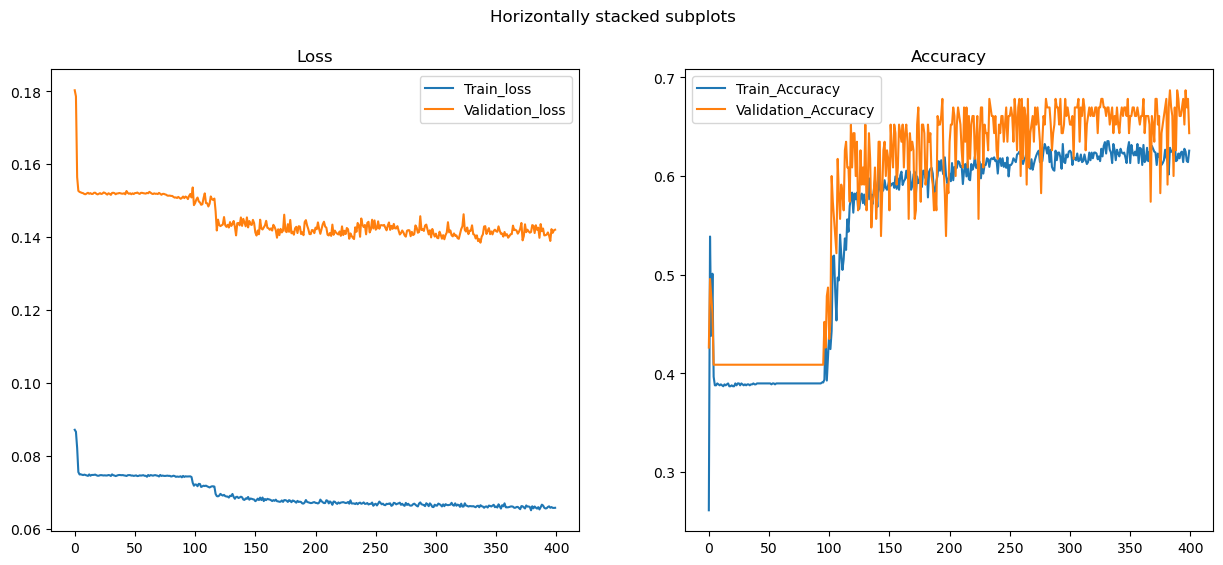

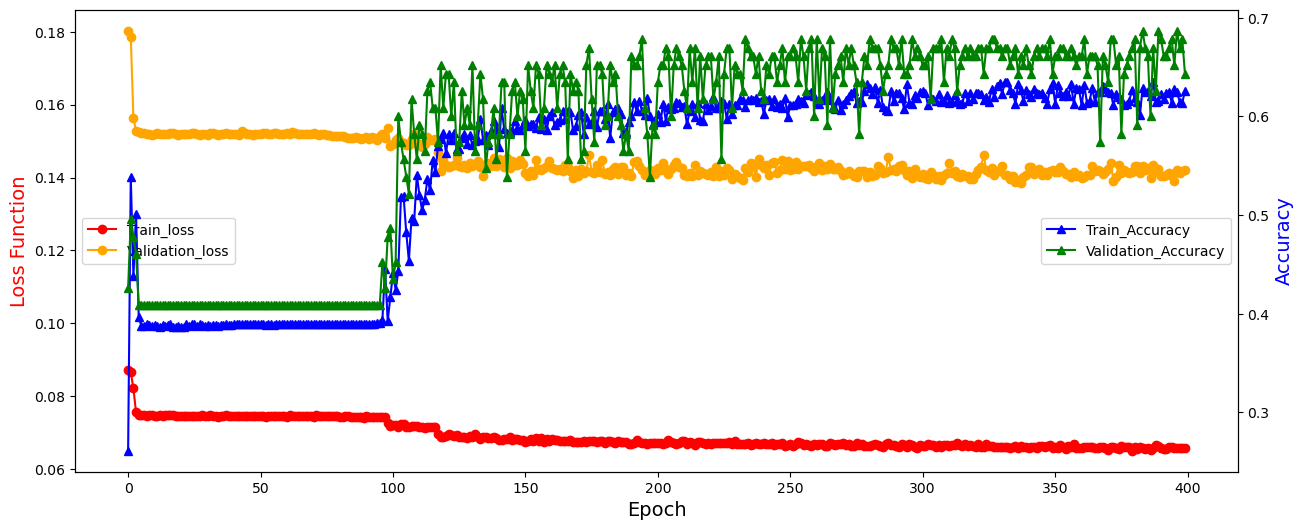

Current time: 68.412 minutes. Time expected till completion: 17.103 minutes

Epoch 401 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06548076597127048
Val loss:  0.1418126158092333
train accuracy:  0.6170212765957447
Val accuracy:  0.6782608695652174
Current time: 68.584 minutes. Time expected till completion: 16.932 minutes

Epoch 402 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.06585766158897134
Val loss:  0.14055614626925925
train accuracy:  0.6237911025145068
Val accuracy:  0.6347826086956522
Current time: 68.751 minutes. Time expected till completion: 16.760 minutes

Epoch 403 of 500


100%|██████████| 15/15 [00:00<00:00, 32.84it/s]


train loss:  0.0653454919617688
Val loss:  0.14377728389657063
train accuracy:  0.6305609284332688
Val accuracy:  0.591304347826087
Current time: 68.921 minutes. Time expected till completion: 16.589 minutes

Epoch 404 of 500


100%|██████████| 15/15 [00:00<00:00, 33.35it/s]


train loss:  0.06617216463245783
Val loss:  0.14220112095708431
train accuracy:  0.6179883945841392
Val accuracy:  0.6782608695652174
Current time: 69.091 minutes. Time expected till completion: 16.418 minutes

Epoch 405 of 500


100%|██████████| 15/15 [00:00<00:00, 33.20it/s]


train loss:  0.0653565975061007
Val loss:  0.14296817002089127
train accuracy:  0.6392649903288201
Val accuracy:  0.6260869565217392
Current time: 69.257 minutes. Time expected till completion: 16.246 minutes

Epoch 406 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06550956763889158
Val loss:  0.14162324563316678
train accuracy:  0.6315280464216635
Val accuracy:  0.6782608695652174
Current time: 69.427 minutes. Time expected till completion: 16.074 minutes

Epoch 407 of 500


100%|██████████| 15/15 [00:00<00:00, 30.76it/s]


train loss:  0.0655433257151849
Val loss:  0.14043421641640041
train accuracy:  0.6160541586073501
Val accuracy:  0.6695652173913044
Current time: 69.599 minutes. Time expected till completion: 15.904 minutes

Epoch 408 of 500


100%|██████████| 15/15 [00:00<00:00, 34.26it/s]


train loss:  0.06591885261655546
Val loss:  0.14225542130677596
train accuracy:  0.6295938104448743
Val accuracy:  0.6695652173913044
Current time: 69.766 minutes. Time expected till completion: 15.732 minutes

Epoch 409 of 500


100%|██████████| 15/15 [00:00<00:00, 32.21it/s]


train loss:  0.06561797332717556
Val loss:  0.1424956430559573
train accuracy:  0.6295938104448743
Val accuracy:  0.6869565217391305
Current time: 69.934 minutes. Time expected till completion: 15.560 minutes

Epoch 410 of 500


100%|██████████| 15/15 [00:00<00:00, 31.07it/s]


train loss:  0.06553954427892511
Val loss:  0.14160031028415845
train accuracy:  0.6199226305609284
Val accuracy:  0.6695652173913044
Current time: 70.104 minutes. Time expected till completion: 15.389 minutes

Epoch 411 of 500


100%|██████████| 15/15 [00:00<00:00, 33.27it/s]


train loss:  0.06532765005497222
Val loss:  0.14286297456077907
train accuracy:  0.6373307543520309
Val accuracy:  0.6695652173913044
Current time: 70.272 minutes. Time expected till completion: 15.217 minutes

Epoch 412 of 500


100%|██████████| 15/15 [00:00<00:00, 32.55it/s]


train loss:  0.06550604174169397
Val loss:  0.14331807416418324
train accuracy:  0.6247582205029013
Val accuracy:  0.6260869565217392
Current time: 70.439 minutes. Time expected till completion: 15.045 minutes

Epoch 413 of 500


100%|██████████| 15/15 [00:00<00:00, 29.26it/s]


train loss:  0.06583627856676998
Val loss:  0.14216675499211187
train accuracy:  0.6276595744680851
Val accuracy:  0.6260869565217392
Current time: 70.608 minutes. Time expected till completion: 14.874 minutes

Epoch 414 of 500


100%|██████████| 15/15 [00:00<00:00, 32.98it/s]


train loss:  0.06609534450610326
Val loss:  0.14097044001454892
train accuracy:  0.6382978723404256
Val accuracy:  0.6434782608695652
Current time: 70.779 minutes. Time expected till completion: 14.703 minutes

Epoch 415 of 500


100%|██████████| 15/15 [00:00<00:00, 32.41it/s]


train loss:  0.06529826876964975
Val loss:  0.14056164803712265
train accuracy:  0.6276595744680851
Val accuracy:  0.6434782608695652
Current time: 70.950 minutes. Time expected till completion: 14.532 minutes

Epoch 416 of 500


100%|██████████| 15/15 [00:00<00:00, 33.87it/s]


train loss:  0.06567313690711267
Val loss:  0.1403511809266132
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 71.117 minutes. Time expected till completion: 14.360 minutes

Epoch 417 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06546707719391504
Val loss:  0.14245606919993525
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 71.288 minutes. Time expected till completion: 14.189 minutes

Epoch 418 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.06571987104139199
Val loss:  0.14239847400914069
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 71.458 minutes. Time expected till completion: 14.018 minutes

Epoch 419 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06559669049150478
Val loss:  0.14054007219231646
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 71.625 minutes. Time expected till completion: 13.846 minutes

Epoch 420 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.06528118638973864
Val loss:  0.14164167642593384
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 71.796 minutes. Time expected till completion: 13.675 minutes

Epoch 421 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.06547002445337159
Val loss:  0.1456179370050845
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 71.965 minutes. Time expected till completion: 13.504 minutes

Epoch 422 of 500


100%|██████████| 15/15 [00:00<00:00, 33.27it/s]


train loss:  0.06493614299846111
Val loss:  0.1422854376875836
train accuracy:  0.6334622823984526
Val accuracy:  0.6782608695652174
Current time: 72.136 minutes. Time expected till completion: 13.333 minutes

Epoch 423 of 500


100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


train loss:  0.06553105528626728
Val loss:  0.1422272397124249
train accuracy:  0.6150870406189555
Val accuracy:  0.6782608695652174
Current time: 72.308 minutes. Time expected till completion: 13.162 minutes

Epoch 424 of 500


100%|██████████| 15/15 [00:00<00:00, 31.20it/s]


train loss:  0.06516445046236713
Val loss:  0.14097557534342225
train accuracy:  0.6286266924564797
Val accuracy:  0.6782608695652174
Current time: 72.476 minutes. Time expected till completion: 12.991 minutes

Epoch 425 of 500


100%|██████████| 15/15 [00:00<00:00, 33.65it/s]


train loss:  0.0654699743601063
Val loss:  0.14273702528165735
train accuracy:  0.6334622823984526
Val accuracy:  0.6782608695652174
Current time: 72.647 minutes. Time expected till completion: 12.820 minutes

Epoch 426 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.06543996543902723
Val loss:  0.14184846618901129
train accuracy:  0.625725338491296
Val accuracy:  0.6695652173913044
Current time: 72.822 minutes. Time expected till completion: 12.650 minutes

Epoch 427 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.0656394829948359
Val loss:  0.14064605132393215
train accuracy:  0.6276595744680851
Val accuracy:  0.6434782608695652
Current time: 72.994 minutes. Time expected till completion: 12.479 minutes

Epoch 428 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.06505471433384967
Val loss:  0.14163195568582285
train accuracy:  0.6228239845261122
Val accuracy:  0.6782608695652174
Current time: 73.165 minutes. Time expected till completion: 12.308 minutes

Epoch 429 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06480850841367268
Val loss:  0.14395775432172028
train accuracy:  0.632495164410058
Val accuracy:  0.6782608695652174
Current time: 73.334 minutes. Time expected till completion: 12.137 minutes

Epoch 430 of 500


100%|██████████| 15/15 [00:00<00:00, 31.20it/s]


train loss:  0.06582005071224972
Val loss:  0.1421507866486259
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 73.502 minutes. Time expected till completion: 11.965 minutes

Epoch 431 of 500


100%|██████████| 15/15 [00:00<00:00, 32.21it/s]


train loss:  0.06550879900413971
Val loss:  0.14060718857723734
train accuracy:  0.6382978723404256
Val accuracy:  0.6260869565217392
Current time: 73.677 minutes. Time expected till completion: 11.795 minutes

Epoch 432 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06569854497217809
Val loss:  0.14177239770474642
train accuracy:  0.6286266924564797
Val accuracy:  0.6782608695652174
Current time: 73.845 minutes. Time expected till completion: 11.624 minutes

Epoch 433 of 500


100%|██████████| 15/15 [00:00<00:00, 32.84it/s]


train loss:  0.06558309008351147
Val loss:  0.14198443993278173
train accuracy:  0.6392649903288201
Val accuracy:  0.6608695652173913
Current time: 74.015 minutes. Time expected till completion: 11.453 minutes

Epoch 434 of 500


100%|██████████| 15/15 [00:00<00:00, 32.48it/s]


train loss:  0.06562562474199143
Val loss:  0.1424446401388749
train accuracy:  0.6247582205029013
Val accuracy:  0.6695652173913044
Current time: 74.186 minutes. Time expected till completion: 11.282 minutes

Epoch 435 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.06498845627736768
Val loss:  0.14310541360274606
train accuracy:  0.6334622823984526
Val accuracy:  0.6521739130434783
Current time: 74.352 minutes. Time expected till completion: 11.110 minutes

Epoch 436 of 500


100%|██████████| 15/15 [00:00<00:00, 32.98it/s]


train loss:  0.06492526941649919
Val loss:  0.14367424664290054
train accuracy:  0.6266924564796905
Val accuracy:  0.6695652173913044
Current time: 74.521 minutes. Time expected till completion: 10.939 minutes

Epoch 437 of 500


100%|██████████| 15/15 [00:00<00:00, 32.07it/s]


train loss:  0.065377613792567
Val loss:  0.14182086820187775
train accuracy:  0.6295938104448743
Val accuracy:  0.6869565217391305
Current time: 74.692 minutes. Time expected till completion: 10.768 minutes

Epoch 438 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.06508869543758075
Val loss:  0.13951446750889654
train accuracy:  0.6363636363636364
Val accuracy:  0.6782608695652174
Current time: 74.859 minutes. Time expected till completion: 10.597 minutes

Epoch 439 of 500


100%|██████████| 15/15 [00:00<00:00, 30.95it/s]


train loss:  0.0653789838923707
Val loss:  0.14363594625307166
train accuracy:  0.6315280464216635
Val accuracy:  0.6869565217391305
Current time: 75.032 minutes. Time expected till completion: 10.426 minutes

Epoch 440 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.06483087606540731
Val loss:  0.13877344390620355
train accuracy:  0.6373307543520309
Val accuracy:  0.6434782608695652
Current time: 75.204 minutes. Time expected till completion: 10.255 minutes

Epoch 441 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06526933918838575
Val loss:  0.1401809889337291
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 75.372 minutes. Time expected till completion: 10.084 minutes

Epoch 442 of 500


100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


train loss:  0.06564753325349819
Val loss:  0.14068288440289706
train accuracy:  0.6334622823984526
Val accuracy:  0.6869565217391305
Current time: 75.541 minutes. Time expected till completion: 9.913 minutes

Epoch 443 of 500


100%|██████████| 15/15 [00:00<00:00, 30.76it/s]


train loss:  0.06505564806309153
Val loss:  0.13978680527728538
train accuracy:  0.6315280464216635
Val accuracy:  0.6695652173913044
Current time: 75.713 minutes. Time expected till completion: 9.742 minutes

Epoch 444 of 500


100%|██████████| 15/15 [00:00<00:00, 32.91it/s]


train loss:  0.06527325810731265
Val loss:  0.14139441614565643
train accuracy:  0.6295938104448743
Val accuracy:  0.6869565217391305
Current time: 75.882 minutes. Time expected till completion: 9.571 minutes

Epoch 445 of 500


100%|██████████| 15/15 [00:00<00:00, 33.87it/s]


train loss:  0.06547100902526014
Val loss:  0.14058941239896028
train accuracy:  0.6353965183752418
Val accuracy:  0.6434782608695652
Current time: 76.054 minutes. Time expected till completion: 9.400 minutes

Epoch 446 of 500


100%|██████████| 15/15 [00:00<00:00, 30.57it/s]


train loss:  0.06522429439039248
Val loss:  0.1405454158782959
train accuracy:  0.6305609284332688
Val accuracy:  0.6347826086956522
Current time: 76.223 minutes. Time expected till completion: 9.229 minutes

Epoch 447 of 500


100%|██████████| 15/15 [00:00<00:00, 32.41it/s]


train loss:  0.0659505110414162
Val loss:  0.14053025038346
train accuracy:  0.6363636363636364
Val accuracy:  0.6608695652173913
Current time: 76.394 minutes. Time expected till completion: 9.058 minutes

Epoch 448 of 500


100%|██████████| 15/15 [00:00<00:00, 30.95it/s]


train loss:  0.06548535431837897
Val loss:  0.13881293638892797
train accuracy:  0.6179883945841392
Val accuracy:  0.6782608695652174
Current time: 76.564 minutes. Time expected till completion: 8.887 minutes

Epoch 449 of 500


100%|██████████| 15/15 [00:00<00:00, 30.82it/s]


train loss:  0.06538988099338007
Val loss:  0.1432028547577236
train accuracy:  0.6315280464216635
Val accuracy:  0.6695652173913044
Current time: 76.732 minutes. Time expected till completion: 8.716 minutes

Epoch 450 of 500


100%|██████████| 15/15 [00:00<00:00, 33.87it/s]


train loss:  0.06530399404365274
Val loss:  0.142398550717727
train accuracy:  0.6305609284332688
Val accuracy:  0.6695652173913044
Current time: 76.904 minutes. Time expected till completion: 8.545 minutes

Epoch 451 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06546714204422971
Val loss:  0.14169428504031636
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 77.076 minutes. Time expected till completion: 8.374 minutes

Epoch 452 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06510552717823125
Val loss:  0.14127296468485956
train accuracy:  0.6411992263056093
Val accuracy:  0.6608695652173913
Current time: 77.244 minutes. Time expected till completion: 8.203 minutes

Epoch 453 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06502134507122077
Val loss:  0.14252349915711776
train accuracy:  0.6411992263056093
Val accuracy:  0.6695652173913044
Current time: 77.417 minutes. Time expected till completion: 8.032 minutes

Epoch 454 of 500


100%|██████████| 15/15 [00:00<00:00, 30.95it/s]


train loss:  0.0650136607412674
Val loss:  0.1425882064777872
train accuracy:  0.6392649903288201
Val accuracy:  0.6782608695652174
Current time: 77.587 minutes. Time expected till completion: 7.861 minutes

Epoch 455 of 500


100%|██████████| 15/15 [00:00<00:00, 30.82it/s]


train loss:  0.06469533233624132
Val loss:  0.14225822220677914
train accuracy:  0.6247582205029013
Val accuracy:  0.6695652173913044
Current time: 77.755 minutes. Time expected till completion: 7.690 minutes

Epoch 456 of 500


100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


train loss:  0.06542100418697704
Val loss:  0.14135369114253832
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 77.926 minutes. Time expected till completion: 7.519 minutes

Epoch 457 of 500


100%|██████████| 15/15 [00:00<00:00, 30.76it/s]


train loss:  0.065697251021055
Val loss:  0.1422661568807519
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 78.095 minutes. Time expected till completion: 7.348 minutes

Epoch 458 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.06571168727754854
Val loss:  0.13989298758299454
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 78.266 minutes. Time expected till completion: 7.177 minutes

Epoch 459 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06524969213705228
Val loss:  0.14157619683638864
train accuracy:  0.6353965183752418
Val accuracy:  0.6608695652173913
Current time: 78.437 minutes. Time expected till completion: 7.006 minutes

Epoch 460 of 500


100%|██████████| 15/15 [00:00<00:00, 30.08it/s]


train loss:  0.06476732419814547
Val loss:  0.14342524124228437
train accuracy:  0.6353965183752418
Val accuracy:  0.6608695652173913
Current time: 78.607 minutes. Time expected till completion: 6.835 minutes

Epoch 461 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06553722240708092
Val loss:  0.14171159008274908
train accuracy:  0.6363636363636364
Val accuracy:  0.6434782608695652
Current time: 78.778 minutes. Time expected till completion: 6.664 minutes

Epoch 462 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.06577571557845553
Val loss:  0.14157287452531897
train accuracy:  0.6382978723404256
Val accuracy:  0.6695652173913044
Current time: 78.951 minutes. Time expected till completion: 6.494 minutes

Epoch 463 of 500


100%|██████████| 15/15 [00:00<00:00, 34.03it/s]


train loss:  0.06547975257701985
Val loss:  0.1419366504835046
train accuracy:  0.6431334622823984
Val accuracy:  0.6695652173913044
Current time: 79.116 minutes. Time expected till completion: 6.322 minutes

Epoch 464 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.06520864125377204
Val loss:  0.13969718632490738
train accuracy:  0.6382978723404256
Val accuracy:  0.6608695652173913
Current time: 79.287 minutes. Time expected till completion: 6.152 minutes

Epoch 465 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.06574060728978834
Val loss:  0.14027055761088494
train accuracy:  0.6353965183752418
Val accuracy:  0.6608695652173913
Current time: 79.457 minutes. Time expected till completion: 5.981 minutes

Epoch 466 of 500


100%|██████████| 15/15 [00:00<00:00, 33.57it/s]


train loss:  0.06539852666439816
Val loss:  0.14460420245709626
train accuracy:  0.6450676982591876
Val accuracy:  0.6608695652173913
Current time: 79.625 minutes. Time expected till completion: 5.810 minutes

Epoch 467 of 500


100%|██████████| 15/15 [00:00<00:00, 33.42it/s]


train loss:  0.06479802393359879
Val loss:  0.14191268423329229
train accuracy:  0.6450676982591876
Val accuracy:  0.6260869565217392
Current time: 79.799 minutes. Time expected till completion: 5.639 minutes

Epoch 468 of 500


100%|██████████| 15/15 [00:00<00:00, 30.14it/s]


train loss:  0.06546616536966837
Val loss:  0.14230745875317116
train accuracy:  0.6266924564796905
Val accuracy:  0.6782608695652174
Current time: 79.972 minutes. Time expected till completion: 5.468 minutes

Epoch 469 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.06563248175486375
Val loss:  0.14329421105592147
train accuracy:  0.6392649903288201
Val accuracy:  0.6608695652173913
Current time: 80.147 minutes. Time expected till completion: 5.298 minutes

Epoch 470 of 500


100%|██████████| 15/15 [00:00<00:00, 33.06it/s]


train loss:  0.06490201541948595
Val loss:  0.1412458984748177
train accuracy:  0.6373307543520309
Val accuracy:  0.6782608695652174
Current time: 80.316 minutes. Time expected till completion: 5.127 minutes

Epoch 471 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06548042252400396
Val loss:  0.14070812826571258
train accuracy:  0.620889748549323
Val accuracy:  0.6695652173913044
Current time: 80.483 minutes. Time expected till completion: 4.955 minutes

Epoch 472 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.0648140888841286
Val loss:  0.14091996887455815
train accuracy:  0.6315280464216635
Val accuracy:  0.6695652173913044
Current time: 80.653 minutes. Time expected till completion: 4.785 minutes

Epoch 473 of 500


100%|██████████| 15/15 [00:00<00:00, 32.21it/s]


train loss:  0.0647325975751969
Val loss:  0.14026700983876766
train accuracy:  0.6305609284332688
Val accuracy:  0.6869565217391305
Current time: 80.822 minutes. Time expected till completion: 4.614 minutes

Epoch 474 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06486816960792247
Val loss:  0.141870147248973
train accuracy:  0.6353965183752418
Val accuracy:  0.6782608695652174
Current time: 80.988 minutes. Time expected till completion: 4.442 minutes

Epoch 475 of 500


100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


train loss:  0.06532998668386582
Val loss:  0.1424893503603728
train accuracy:  0.6286266924564797
Val accuracy:  0.6434782608695652
Current time: 81.157 minutes. Time expected till completion: 4.271 minutes

Epoch 476 of 500


100%|██████████| 15/15 [00:00<00:00, 31.07it/s]


train loss:  0.06489900924712132
Val loss:  0.14366206708161727
train accuracy:  0.625725338491296
Val accuracy:  0.6695652173913044
Current time: 81.325 minutes. Time expected till completion: 4.100 minutes

Epoch 477 of 500


100%|██████████| 15/15 [00:00<00:00, 32.55it/s]


train loss:  0.06503353566219544
Val loss:  0.14247316122055054
train accuracy:  0.6373307543520309
Val accuracy:  0.6695652173913044
Current time: 81.493 minutes. Time expected till completion: 3.929 minutes

Epoch 478 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06490249462007784
Val loss:  0.1420302416967309
train accuracy:  0.632495164410058
Val accuracy:  0.6608695652173913
Current time: 81.667 minutes. Time expected till completion: 3.759 minutes

Epoch 479 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.06482450966678228
Val loss:  0.14303187494692596
train accuracy:  0.6382978723404256
Val accuracy:  0.6695652173913044
Current time: 81.834 minutes. Time expected till completion: 3.588 minutes

Epoch 480 of 500


100%|██████████| 15/15 [00:00<00:00, 32.84it/s]


train loss:  0.06513707953679954
Val loss:  0.14190746545791627
train accuracy:  0.6353965183752418
Val accuracy:  0.6695652173913044
Current time: 82.000 minutes. Time expected till completion: 3.417 minutes

Epoch 481 of 500


100%|██████████| 15/15 [00:00<00:00, 33.80it/s]


train loss:  0.06549260786930873
Val loss:  0.14251415107561194
train accuracy:  0.6266924564796905
Val accuracy:  0.6782608695652174
Current time: 82.171 minutes. Time expected till completion: 3.246 minutes

Epoch 482 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06462387605146928
Val loss:  0.14316966430000636
train accuracy:  0.6334622823984526
Val accuracy:  0.6695652173913044
Current time: 82.340 minutes. Time expected till completion: 3.075 minutes

Epoch 483 of 500


100%|██████████| 15/15 [00:00<00:00, 33.35it/s]


train loss:  0.06495566265495419
Val loss:  0.14269383368284805
train accuracy:  0.6295938104448743
Val accuracy:  0.6695652173913044
Current time: 82.511 minutes. Time expected till completion: 2.904 minutes

Epoch 484 of 500


100%|██████████| 15/15 [00:00<00:00, 32.98it/s]


train loss:  0.06515095779236327
Val loss:  0.14372076262598452
train accuracy:  0.632495164410058
Val accuracy:  0.6608695652173913
Current time: 82.679 minutes. Time expected till completion: 2.733 minutes

Epoch 485 of 500


100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


train loss:  0.06473176576182736
Val loss:  0.14195052229839822
train accuracy:  0.6315280464216635
Val accuracy:  0.6782608695652174
Current time: 82.850 minutes. Time expected till completion: 2.562 minutes

Epoch 486 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06524844672278694
Val loss:  0.1424585161001786
train accuracy:  0.632495164410058
Val accuracy:  0.6608695652173913
Current time: 83.019 minutes. Time expected till completion: 2.391 minutes

Epoch 487 of 500


100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


train loss:  0.06454215710352192
Val loss:  0.14263052266577017
train accuracy:  0.6382978723404256
Val accuracy:  0.6608695652173913
Current time: 83.190 minutes. Time expected till completion: 2.221 minutes

Epoch 488 of 500


100%|██████████| 15/15 [00:00<00:00, 33.06it/s]


train loss:  0.0650407839674553
Val loss:  0.14093266570049784
train accuracy:  0.6402321083172147
Val accuracy:  0.6695652173913044
Current time: 83.358 minutes. Time expected till completion: 2.050 minutes

Epoch 489 of 500


100%|██████████| 15/15 [00:00<00:00, 28.06it/s]


train loss:  0.0648718743190544
Val loss:  0.14038065827411153
train accuracy:  0.6373307543520309
Val accuracy:  0.6695652173913044
Current time: 83.530 minutes. Time expected till completion: 1.879 minutes

Epoch 490 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.06538972558320376
Val loss:  0.1414160780284716
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 83.702 minutes. Time expected till completion: 1.708 minutes

Epoch 491 of 500


100%|██████████| 15/15 [00:00<00:00, 32.21it/s]


train loss:  0.06527480748220846
Val loss:  0.1406836281652036
train accuracy:  0.6392649903288201
Val accuracy:  0.6869565217391305
Current time: 83.872 minutes. Time expected till completion: 1.537 minutes

Epoch 492 of 500


100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


train loss:  0.06463947119749722
Val loss:  0.1408890231795933
train accuracy:  0.6382978723404256
Val accuracy:  0.6608695652173913
Current time: 84.044 minutes. Time expected till completion: 1.367 minutes

Epoch 493 of 500


100%|██████████| 15/15 [00:00<00:00, 31.20it/s]


train loss:  0.0649783794031383
Val loss:  0.14166841040486874
train accuracy:  0.6286266924564797
Val accuracy:  0.6434782608695652
Current time: 84.212 minutes. Time expected till completion: 1.196 minutes

Epoch 494 of 500


100%|██████████| 15/15 [00:00<00:00, 32.07it/s]


train loss:  0.0650338980745762
Val loss:  0.14207949690196825
train accuracy:  0.6421663442940039
Val accuracy:  0.6521739130434783
Current time: 84.380 minutes. Time expected till completion: 1.025 minutes

Epoch 495 of 500


100%|██████████| 15/15 [00:00<00:00, 30.02it/s]


train loss:  0.06532118589089503
Val loss:  0.14224612246388973
train accuracy:  0.6363636363636364
Val accuracy:  0.6782608695652174
Current time: 84.556 minutes. Time expected till completion: 0.854 minutes

Epoch 496 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06445377869117191
Val loss:  0.14136001804600593
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 84.723 minutes. Time expected till completion: 0.683 minutes

Epoch 497 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06501788650306096
Val loss:  0.1424869190091672
train accuracy:  0.6363636363636364
Val accuracy:  0.6695652173913044
Current time: 84.895 minutes. Time expected till completion: 0.512 minutes

Epoch 498 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.06474895236339975
Val loss:  0.14463410740313323
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 85.066 minutes. Time expected till completion: 0.342 minutes

Epoch 499 of 500


100%|██████████| 15/15 [00:00<00:00, 33.65it/s]


train loss:  0.06485528964369164
Val loss:  0.14222212200579437
train accuracy:  0.6421663442940039
Val accuracy:  0.6782608695652174
Current time: 85.235 minutes. Time expected till completion: 0.171 minutes

Epoch 500 of 500


100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


train loss:  0.06463586990100041
Val loss:  0.14345270602599433
train accuracy:  0.6411992263056093
Val accuracy:  0.6695652173913044
Saving model checkpoint


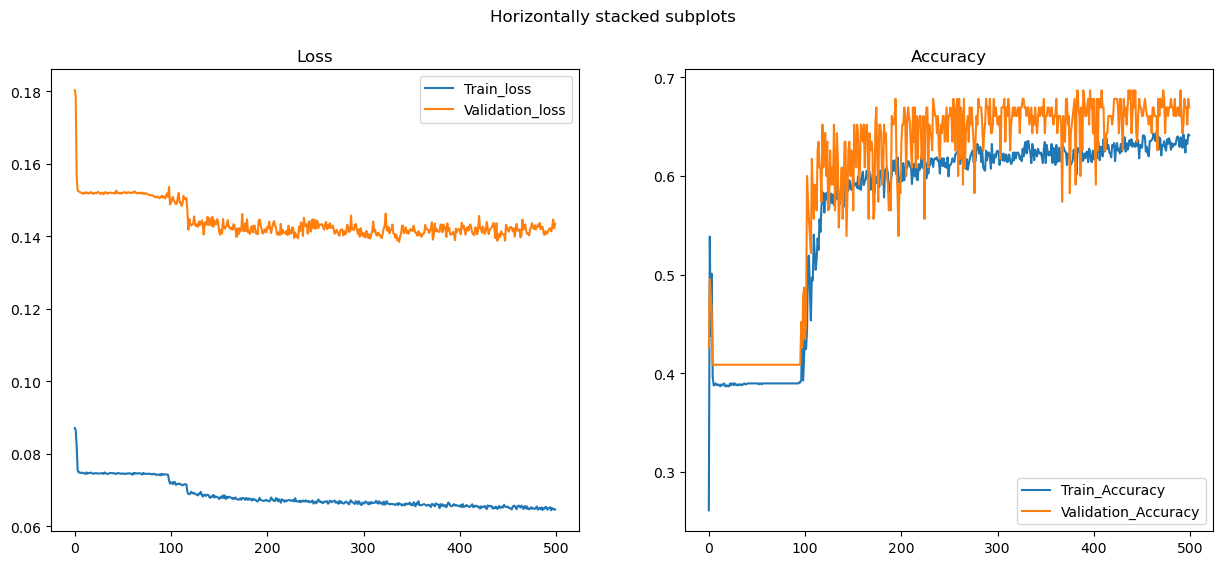

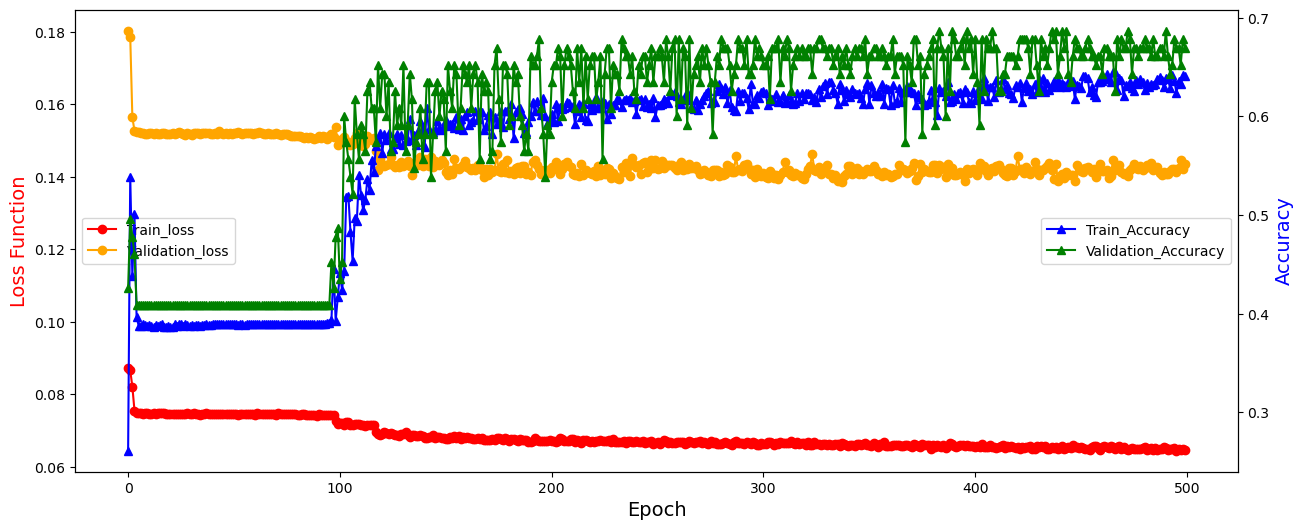

Current time: 85.422 minutes. Time expected till completion: 0.000 minutes
Finished training in: 85.422 minutes


In [15]:
#loader = train_loader # Use the train loader to train
#loader2 = valid_loader
# Main
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

val_loss_withDataAug, val_accuracy_withDataAug = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()
        
# count time
start = time.time()
#PyTorch - Training the Model
for epoch in range(epoch_check, epochs):
    print()
    # Print current epoch
    print(f"Epoch {epoch + 1} of {epochs}")
    
    # Train model
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # in pytorch you have assign the zero for gradien in any sub epoch
        #optim.zero_grad()
        #create the output from the CNN base on the give batch images
        out = modelpy(images)
        # count the loss function 
        loss = criterion(out, labels)
        
        ######################
        optim.zero_grad()#################
        ######################
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        
        # add new value to the main loss
        running_loss += loss.item()
        
        # calculate accuracy
        predictions = torch.argmax(out, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total

    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)

    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        # Save Model
        print("Saving model checkpoint")
        end = time.time()
        time_elapsed = (end-start)+previous_time
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt_"+str(epoch+1)+".pth")
        
        # Cheack the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

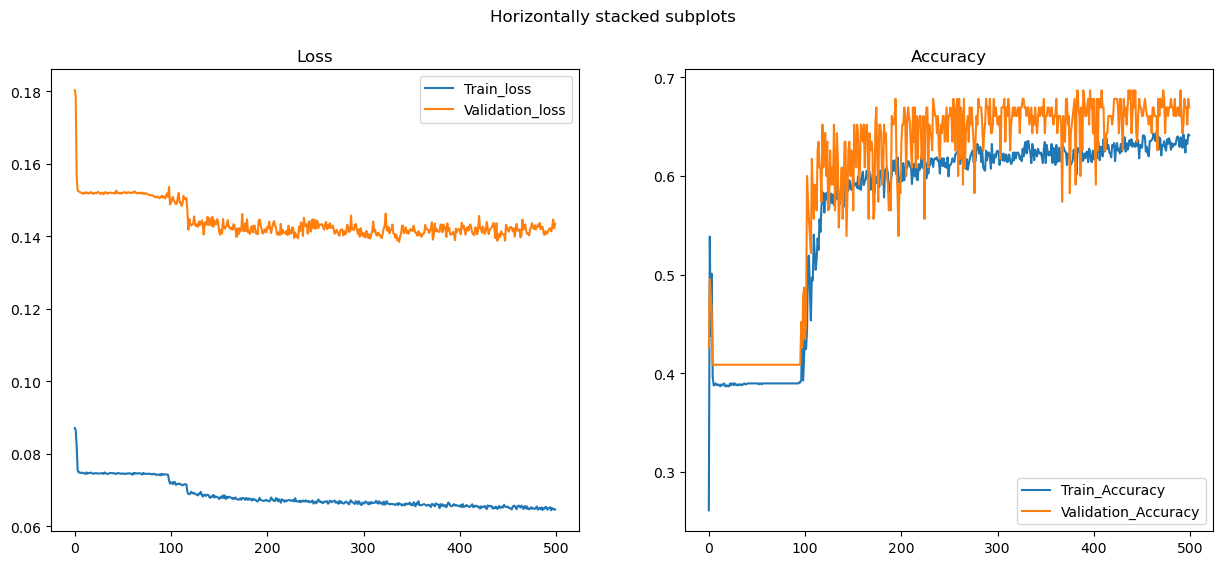

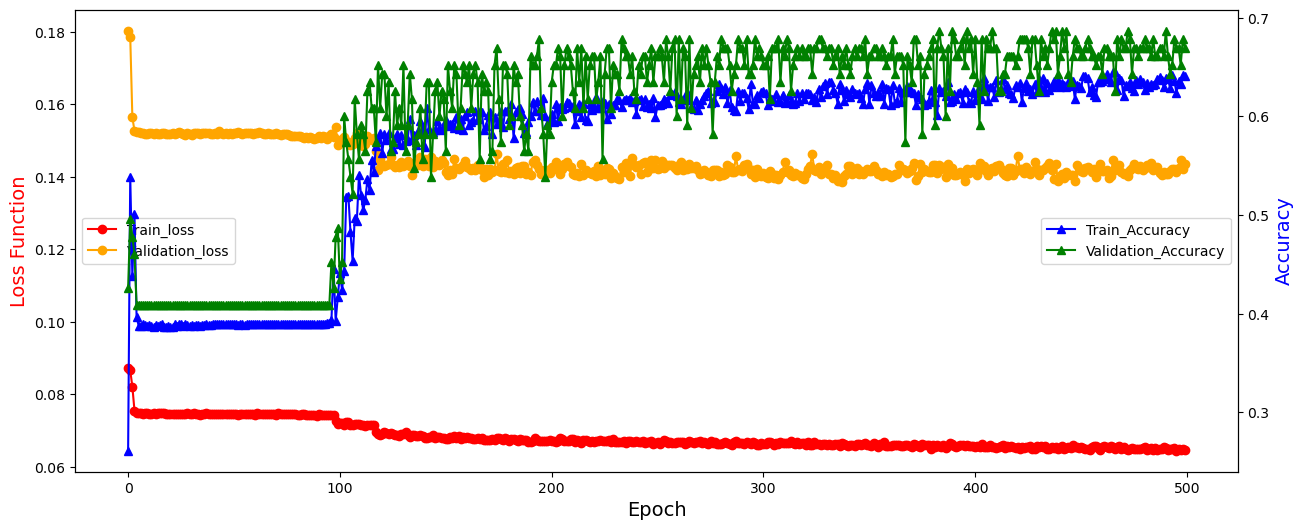

In [16]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

### Save Model

In [17]:
torch.save(modelpy.state_dict(), model_checkpoints + "saved_model_state_dict.pt")
torch.save(modelpy, model_checkpoints + "saved_model.pt")

# 3. Evaluate your model using the developed software

In [18]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

Accuracy of the network on the 1034 Train instances: 62.95938104448743%
Accuracy of the network on the 115 Validation instances: 66.95652173913044%


In [19]:
# Import the test dataset
size_of_resized_img = (224,224) 
test_data, test_names = import_test_folder_dataset_2(test_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", test_data.shape)
print("Dim of Lables: ", test_names.shape)

Dim of Data:  (380, 224, 224, 3)
Dim of Lables:  (380,)


In [20]:
# Create the dataset object
test_Dataset = Data_test_2(test_data, test_names, img_transform_val)#img_transform_val
print("Test len: ",len(test_Dataset))

Test len:  380


In [21]:
# Make the predictions for the test dataset
predictions_list, names = make_predictions(modelpy=modelpy, dataset=test_Dataset, device=device)
len(predictions_list)

380

In [22]:
# Save the Predictions
save_predictions_as_csv(names=names, predictions=predictions_list, name="02_5Conv_0Res_15FChannels.csv")

# 4. Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points